<a href="https://colab.research.google.com/github/climate-and-health-datasci-Unicamp/py-climate-health-toolbox/blob/master/examples/IAC_heatwave_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Heatwave Analyses for IAC's weather station**

In this report, we performed heatwave analyses for the weather station of the Agronomic Institute of Campinas (IAC) in Campinas, SP.

Daily maximum (Tmax) and minimum temperature (Tmin) data from IAC's weather station was used (1956-2018).

-------------------------------------------------------------------------------


*Daniela Souza de Oliveira*¹, *Luiza Marchezan Bezerra*², *Paula Dornhofer Paro Costa*​¹, *Ana Maria Heuminski de Avila*²​, *Eliana Cotta de Faria​*³

¹ Depto. de Eng. de Computação e Automação Industrial, Faculdade de Engenharia Elétrica e de Computação, Universidade Estadual de Campinas (Unicamp)

² Centro de Pesquisas Meteorológicas e Climáticas Aplicadas à Agricultura, CEPAGRI

³ Depto. de Patologia Clínica, Faculdade de Ciências Médicas (FCM), Universidade Estadual de Campinas (Unicamp)

*July, 2020*



--------------------------------------------------------------------------------
**Input file:** *IAC_1890_2018.csv* - Database from IAC already preprocessed and cleaned

**Summary:**

*   Computation of Heatwaves
*   Computation and Description of Yearly and Seasonal Metrics
*   Trend Analyses of Yearly and Seasonal Metrics
*   Heatwaves Intensity

**Output files:** Dataframes HW_IAC (*IAC_HW1956_2018.csv*), pct_IAC (*IAC_pct1956_2018.csv*), HW_IAC_metrics (*IAC_HW_metrics.csv*) and HW_IAC_seasonMetrics (*IAC_HW_seasonMetrics.csv*)

### Installing packages and importing libraries

In [ ]:
#installing Python packages
!pip install -q py-climate-health-toolbox

In [ ]:
 #loading R magic
 %load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
#installing R packages
%%capture
%%R
install.packages('trend', repos='http://cran.rstudio.com/')
install.packages('modifiedmk',repos='http://cran.rstudio.com/')

In [ ]:
#importing Python libraries
import climahe.climatex as tex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

import pymannkendall as mk

In [ ]:
#importing R libraries
%%R
library(readr)
library(modifiedmk)
library(trend)

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Loading Data: IAC_1890_2018.csv


In [ ]:
#Loading data
googl = drive.CreateFile({'id':'1Je4fi5G-DmYxcWVHC8yh0QfOpt1Lt-v6'})
googl.GetContentFile('IAC_1890_2018.csv')


In [ ]:
#Reading data
df_IAC = pd.read_csv('/content/IAC_1890_2018.csv')

In [ ]:
df_IAC.head()

,DATE,YEAR,DAY365,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1890-01-01,1890,1,0.3,24.4,16.6
1,1890-01-02,1890,2,9.0,28.4,15.9
2,1890-01-03,1890,3,2.0,28.9,16.5
3,1890-01-04,1890,4,47.0,30.4,18.0
4,1890-01-05,1890,5,29.0,28.8,17.3


In [ ]:
#checking columns data types
df_IAC.dtypes

DATE             object
YEAR              int64
DAY365            int64
N_RAIN_TOT      float64
N_AIRTMP_MAX    float64
N_AIRTMP_MIN    float64
dtype: object

In [ ]:
#converting column 'DATE' to datetime format
df_IAC['DATE'] = pd.to_datetime(df_IAC['DATE'])
df_IAC.dtypes

DATE            datetime64[ns]
YEAR                     int64
DAY365                   int64
N_RAIN_TOT             float64
N_AIRTMP_MAX           float64
N_AIRTMP_MIN           float64
dtype: object

### Defining Climatological Normal (1961-1990)

In [ ]:
#defining climatological normal
#selecting period from 1961 to 1990
climatic_normal = df_IAC[(df_IAC['YEAR']>1960)&(df_IAC['YEAR']<=1990)]
climatic_normal=climatic_normal.reset_index()
del climatic_normal['index']

climatic_normal

,DATE,YEAR,DAY365,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1961-01-01,1961,1,0.3,27.9,19.0
1,1961-01-02,1961,2,27.4,26.0,19.1
2,1961-01-03,1961,3,47.5,31.4,19.0
3,1961-01-04,1961,4,0.3,27.9,20.0
4,1961-01-05,1961,5,11.9,30.7,18.7
...,...,...,...,...,...,...
10952,1990-12-27,1990,361,0.0,29.8,18.4
10953,1990-12-28,1990,362,0.0,31.2,17.0
10954,1990-12-29,1990,363,3.6,24.6,18.2
10955,1990-12-30,1990,364,4.4,26.0,11.2


### Defining Database (1956-2018)



In [ ]:
#defining database
#selecting data from 1956 to 2018
databaseIAC=df_IAC[(df_IAC['YEAR']>1955)&(df_IAC['YEAR']<=2018)] 
databaseIAC=databaseIAC.reset_index()
del databaseIAC['index']

databaseIAC

,DATE,YEAR,DAY365,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN
0,1956-01-01,1956,1,5.5,30.3,18.8
1,1956-01-02,1956,2,6.6,31.1,19.4
2,1956-01-03,1956,3,13.8,33.1,19.9
3,1956-01-04,1956,4,0.0,31.7,20.1
4,1956-01-05,1956,5,0.7,32.7,19.1
...,...,...,...,...,...,...
23006,2018-12-27,2018,361,0.0,28.8,19.0
23007,2018-12-28,2018,362,23.1,31.2,18.6
23008,2018-12-29,2018,363,0.0,31.7,18.7
23009,2018-12-30,2018,364,0.0,32.1,19.8


In [ ]:
databaseIAC.describe()

,YEAR,DAY365,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN
count,23011.000000,23011.000000,23011.000000,22643.000000,23011.000000
mean,1986.999305,183.127243,3.801195,27.667313,16.184355
std,18.184835,105.442084,10.046020,3.733536,3.335466
min,1956.000000,1.000000,0.000000,10.700000,0.200000
25%,1971.000000,92.000000,0.000000,25.400000,14.000000
50%,1987.000000,183.000000,0.000000,28.000000,16.600000
75%,2003.000000,274.000000,1.300000,30.400000,18.900000
max,2018.000000,366.000000,144.700000,38.300000,25.000000


#### Checking missing data



In [ ]:
databaseIAC.shape

(23011, 6)

In [ ]:
#checking NA values
databaseIAC.isna().sum()

DATE              0
YEAR              0
DAY365            0
N_RAIN_TOT        0
N_AIRTMP_MAX    368
N_AIRTMP_MIN      0
dtype: int64

In [ ]:
#Calculating missing data - maximum temperature
md = 368/23011 * 100
print("Missing maximum temperature data: {:.2f} %".format(md))

Missing maximum temperature data: 1.60 %


## **Computing Heatwaves**

Using function **tex.check_HeatWave** from climatex library

In [ ]:
#checking function parameters
help(tex.check_HeatWave)

Help on function check_HeatWave in module climatex:

check_HeatWave(database, db_columnMAX, db_columnMIN, climatic_normal, pct_columnMAX, pct_columnMIN, db_columnDay365=False, db_complete=False, cn_columnDay365=False, df_pct=None, percentile_value=0.9, window_size=15)
    #-------------------------------------------------------------------------------
    ## Checks for Heat Waves on the database according to the Climatic Normal This
    ## function uses Geirinhas et al. 2018 method. It obtains first a dataframe with
    ## the percentiles computed from the Climatic Normal according to the defined
    ## window size (df_pct). Then compares it with the database, to check if the
    ## maximum and minimum temperatures are above the corresponding percentile. If
    ## the temperatures are above the threshold, the column 'above_pct' receives 1.
    ## This column is then used to identify if there are 3 or more consecutive
    ## extremely warm days (Heat Wave). The column 'HW' then receives

In [ ]:
pd.options.mode.chained_assignment = None # disables SettingWithCopyWarning
#computing heatwaves and percentiles threshold
HW_IAC,pct_IAC = tex.check_HeatWave(databaseIAC,'N_AIRTMP_MAX','N_AIRTMP_MIN',
                           climatic_normal,'N_AIRTMP_MAX','N_AIRTMP_MIN',
                           db_columnDay365=True, db_complete=True, cn_columnDay365=True)

In [ ]:
#percentiles threshold
pct_IAC

,CTX90pct,CTN90pct
DAY365,,
1,31.40,20.2
2,31.53,20.3
3,31.60,20.4
4,31.78,20.4
5,31.80,20.4
...,...,...
361,31.20,20.2
362,31.20,20.1
363,31.17,20.1


In [ ]:
#saving percentiles dataframe locally
pct_IAC.to_csv('IAC_pct1956_2018.csv')

In [ ]:
#heatwaves dataframe
HW_IAC

,DAY365,DATE,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
0,1,1956-01-01,1956,5.5,30.3,18.8,0,0
1,2,1956-01-02,1956,6.6,31.1,19.4,0,0
2,3,1956-01-03,1956,13.8,33.1,19.9,0,0
3,4,1956-01-04,1956,0.0,31.7,20.1,0,0
4,5,1956-01-05,1956,0.7,32.7,19.1,0,0
...,...,...,...,...,...,...,...,...
22990,361,2018-12-27,2018,0.0,28.8,19.0,0,0
22991,362,2018-12-28,2018,23.1,31.2,18.6,0,0
22992,363,2018-12-29,2018,0.0,31.7,18.7,0,0
22993,364,2018-12-30,2018,0.0,32.1,19.8,0,0


In [ ]:
#checking dates with heatwaves (HW = 1)
HW_IAC[HW_IAC['HW']==1]

,DAY365,DATE,YEAR,N_RAIN_TOT,N_AIRTMP_MAX,N_AIRTMP_MIN,above_pct,HW
1344,250,1959-09-07,1959,0.0,35.4,17.1,1,1
1345,251,1959-09-08,1959,0.0,35.5,19.2,1,1
1346,252,1959-09-09,1959,0.0,33.9,18.6,1,1
1369,275,1959-10-02,1959,0.0,35.6,18.4,1,1
1370,276,1959-10-03,1959,0.0,36.4,19.0,1,1
...,...,...,...,...,...,...,...,...
22981,352,2018-12-18,2018,13.5,34.8,21.4,1,1
22982,353,2018-12-19,2018,2.0,33.3,21.5,1,1
22983,354,2018-12-20,2018,0.0,31.7,22.1,1,1
22984,355,2018-12-21,2018,0.0,34.1,21.6,1,1


In [ ]:
#saving database with 'above_pct' and 'HW' columns locally
HW_IAC.to_csv('IAC_HW1956_2018.csv')

## **Metrics**

Using functions **tex.wave_metrics** and **tex.wave_seasonMetrics** from climatex library to obtain yearly and seasonal metrics

### Yearly metrics

Function: *tex.wave_metrics*





In [ ]:
#checking wave_metrics parameters
help(tex.wave_metrics)

Help on function wave_metrics in module climatex:

wave_metrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the yearly metrics of a Heat/Cold Wave given the database
    ## dataframe containing the 'HW'/'CW' column that indicates if a day is inside
    ## of a Heat/Cold Wave or not (check get_wave function). This function obtains
    ## the number of HW/CW events (HWN/CWN), the event with maximum duration
    ## (HWD/CWD) and the cumulative sum of wave durations (HWF) for each year of the
    ## dataframe. These metrics are stored in a dataframe which includes the
    ## Heat/Cold Wave metrics for each year of the database.
    ##
    ## It is possible to plot the metrics (plot=True). For a better adjustment of
    ## the plots, check function plot_oneMetric
    ##
    ## :param      df_checkW:    Database dataframe with the column "HW" or CW"
    ## :type       df_checkW:    pandas.D

In [ ]:
#obtaining yearly metrics
HW_IAC_metrics = tex.wave_metrics(HW_IAC,'HW',plot=False)

In [ ]:
HW_IAC_metrics

,HWN,HWD,HWF
YEAR,,,
1956,0.0,0.0,0.0
1957,0.0,0.0,0.0
1958,0.0,0.0,0.0
1959,2.0,3.0,6.0
1960,1.0,3.0,3.0
...,...,...,...
2014,6.0,11.0,34.0
2015,8.0,8.0,35.0
2016,2.0,10.0,13.0


In [ ]:
#saving yearly metrics dataframe locally
HW_IAC_metrics.to_csv('IAC_HWmetrics.csv')

#### Plotting yearly metrics

Function: *tex.plot_oneMetric*

In [ ]:
help(tex.plot_oneMetric)

Help on function plot_oneMetric in module climatex:

plot_oneMetric(df_metrics, metric, title, lim=None, x_interval=5)
    #-------------------------------------------------------------------------------
    ## Function that plots Heat/Cold yearly wave metric. It receives the yearly
    ## metrics dataframe and the metric to be plotted.
    ##
    ## :param      df_metrics:  Dataframe with yearly metrics ("HWN","HWD","HWF" or
    ##                          "CWN", "CWD","CWF")
    ## :type       df_metrics:  pandas.DataFrame
    ## :param      metric:      Name of the metric to be plotted (e.g. HWN)
    ## :type       metric:      String
    ## :param      title:       Title of the plot
    ## :type       title:       String
    ## :param      lim:         Upper limit of y axis
    ## :type       lim:         Float
    ## :param      x_interval:  Interval of x axis (years interval)
    ## :type       x_interval:  Integer
    ##
    ## :returns:   metric plot
    ## :rtype:     figure
 

##### HWN

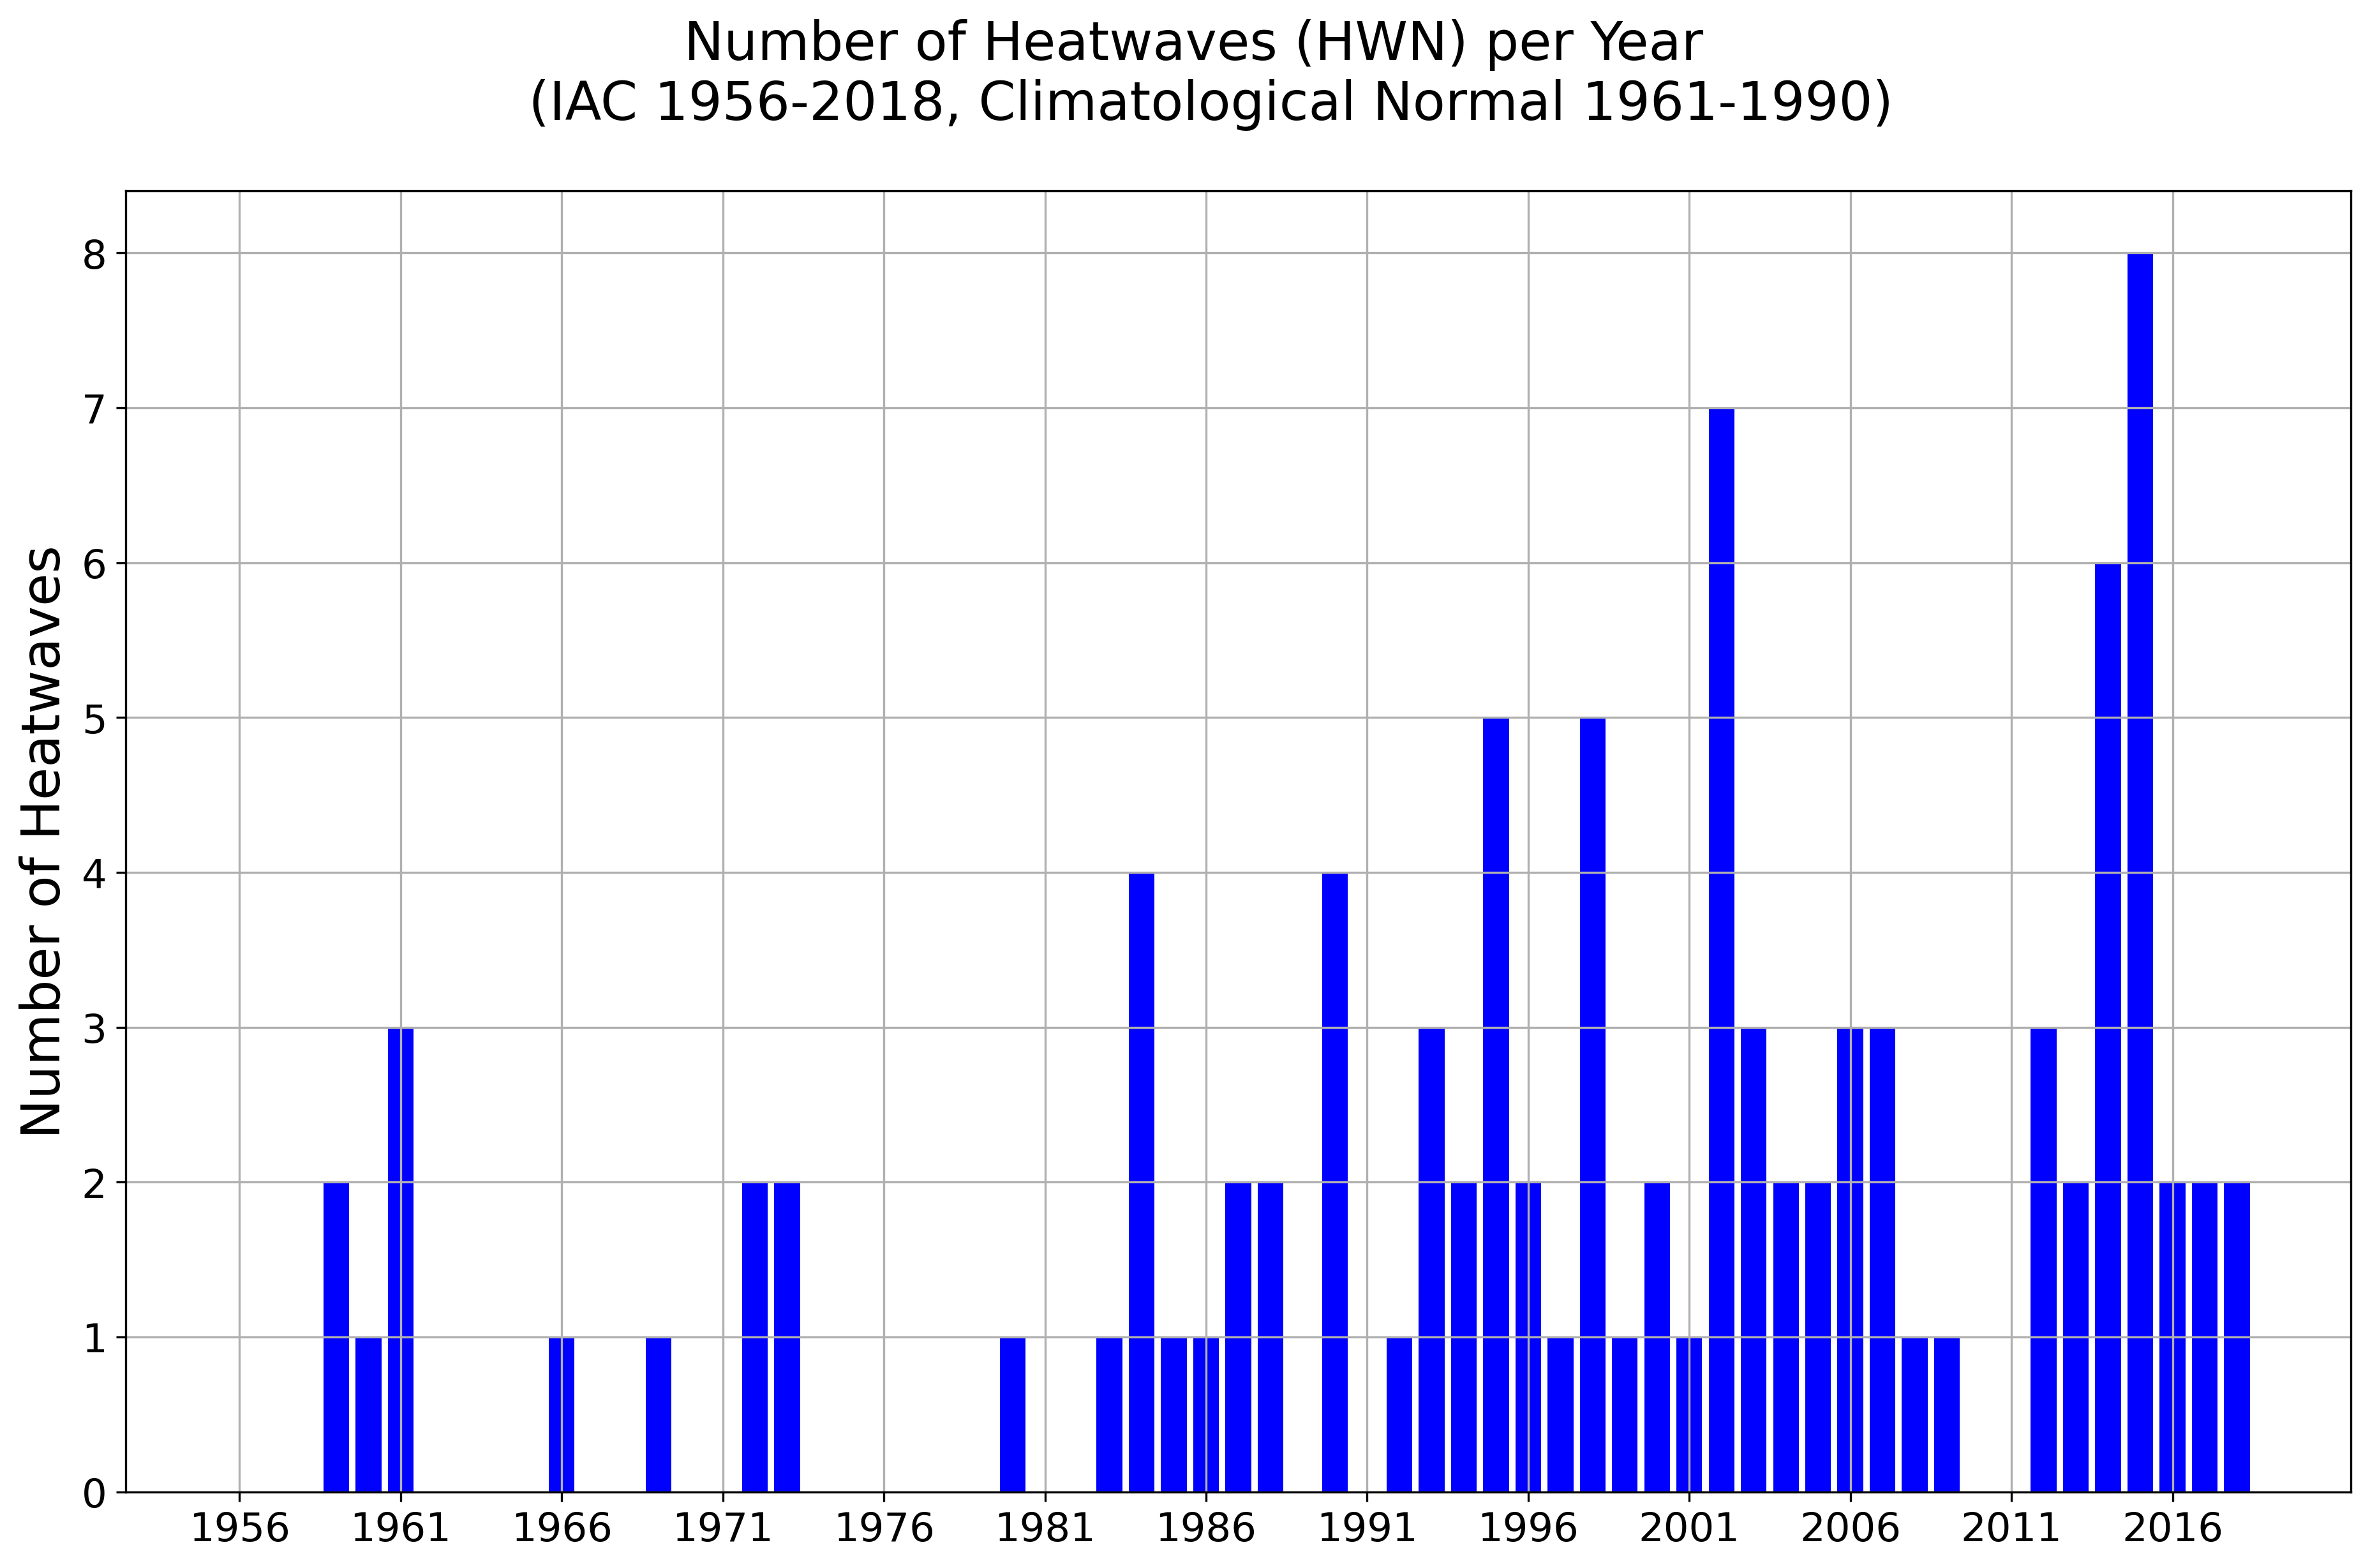

In [ ]:
tex.plot_oneMetric(HW_IAC_metrics,'HWN','Number of Heatwaves (HWN) per Year \n (IAC 1956-2018, Climatological Normal 1961-1990)')

##### HWD

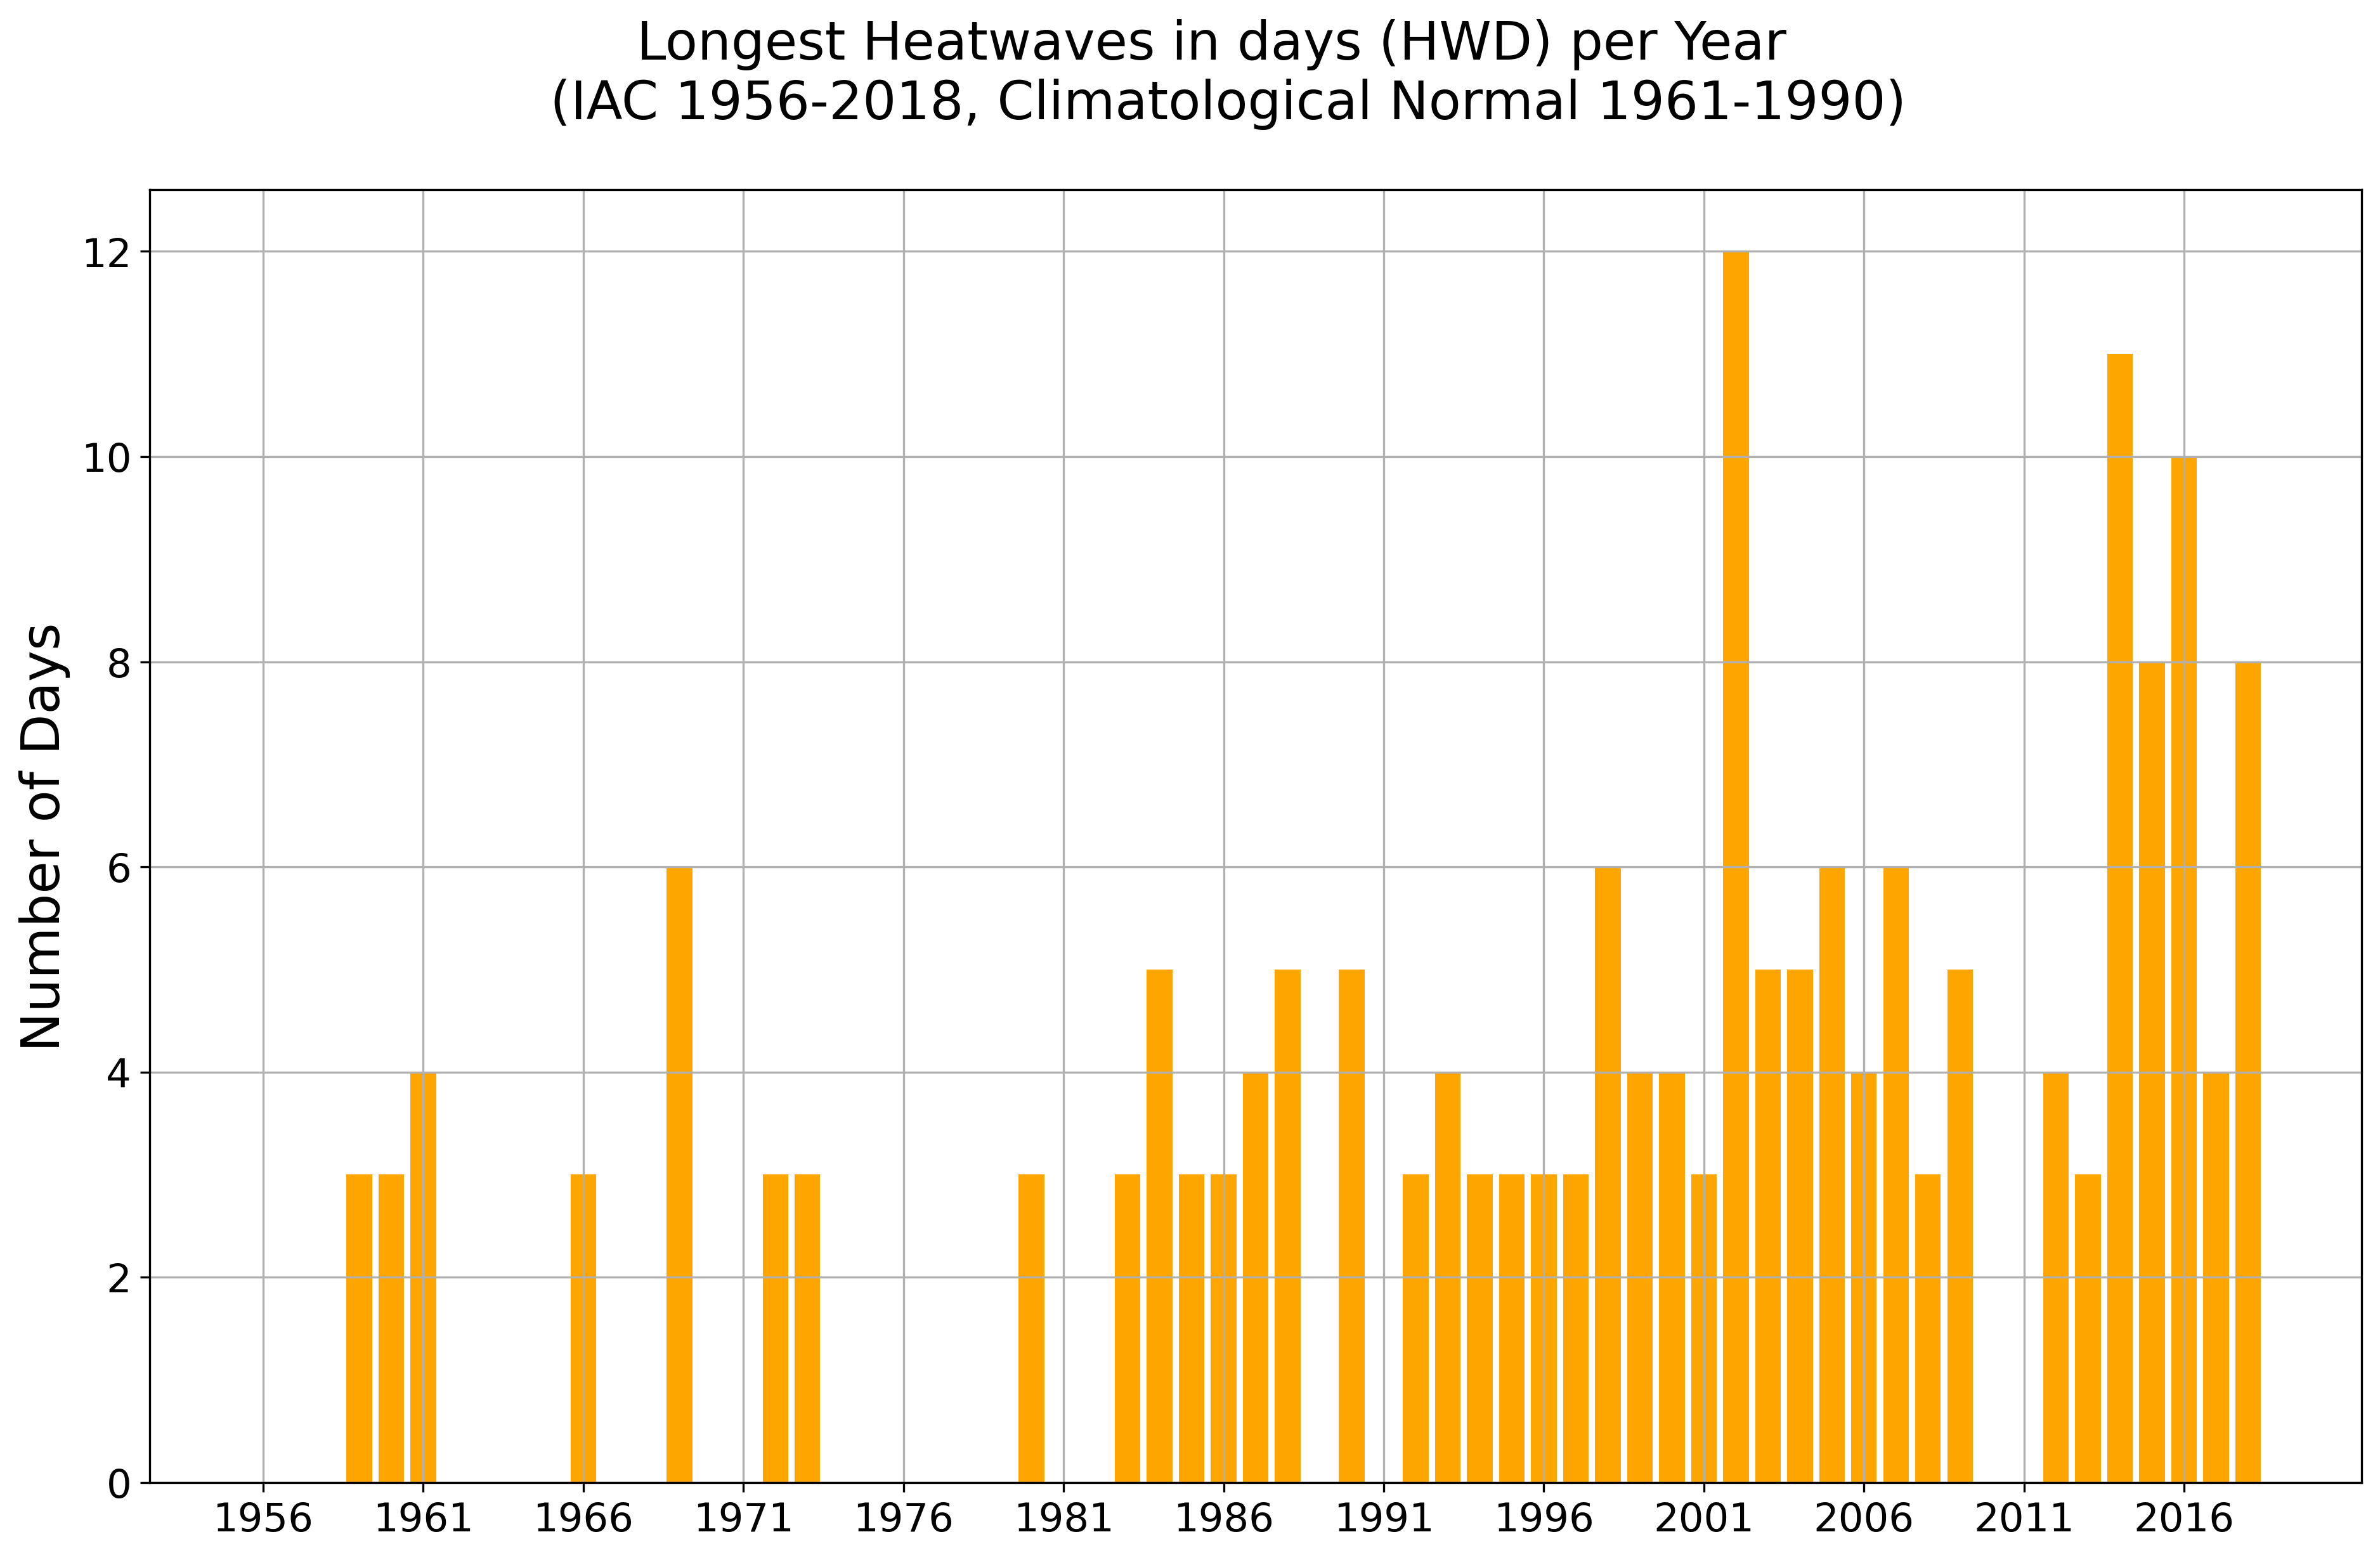

In [ ]:
tex.plot_oneMetric(HW_IAC_metrics,'HWD','Longest Heatwaves in days (HWD) per Year \n (IAC 1956-2018, Climatological Normal 1961-1990)')

##### HWF

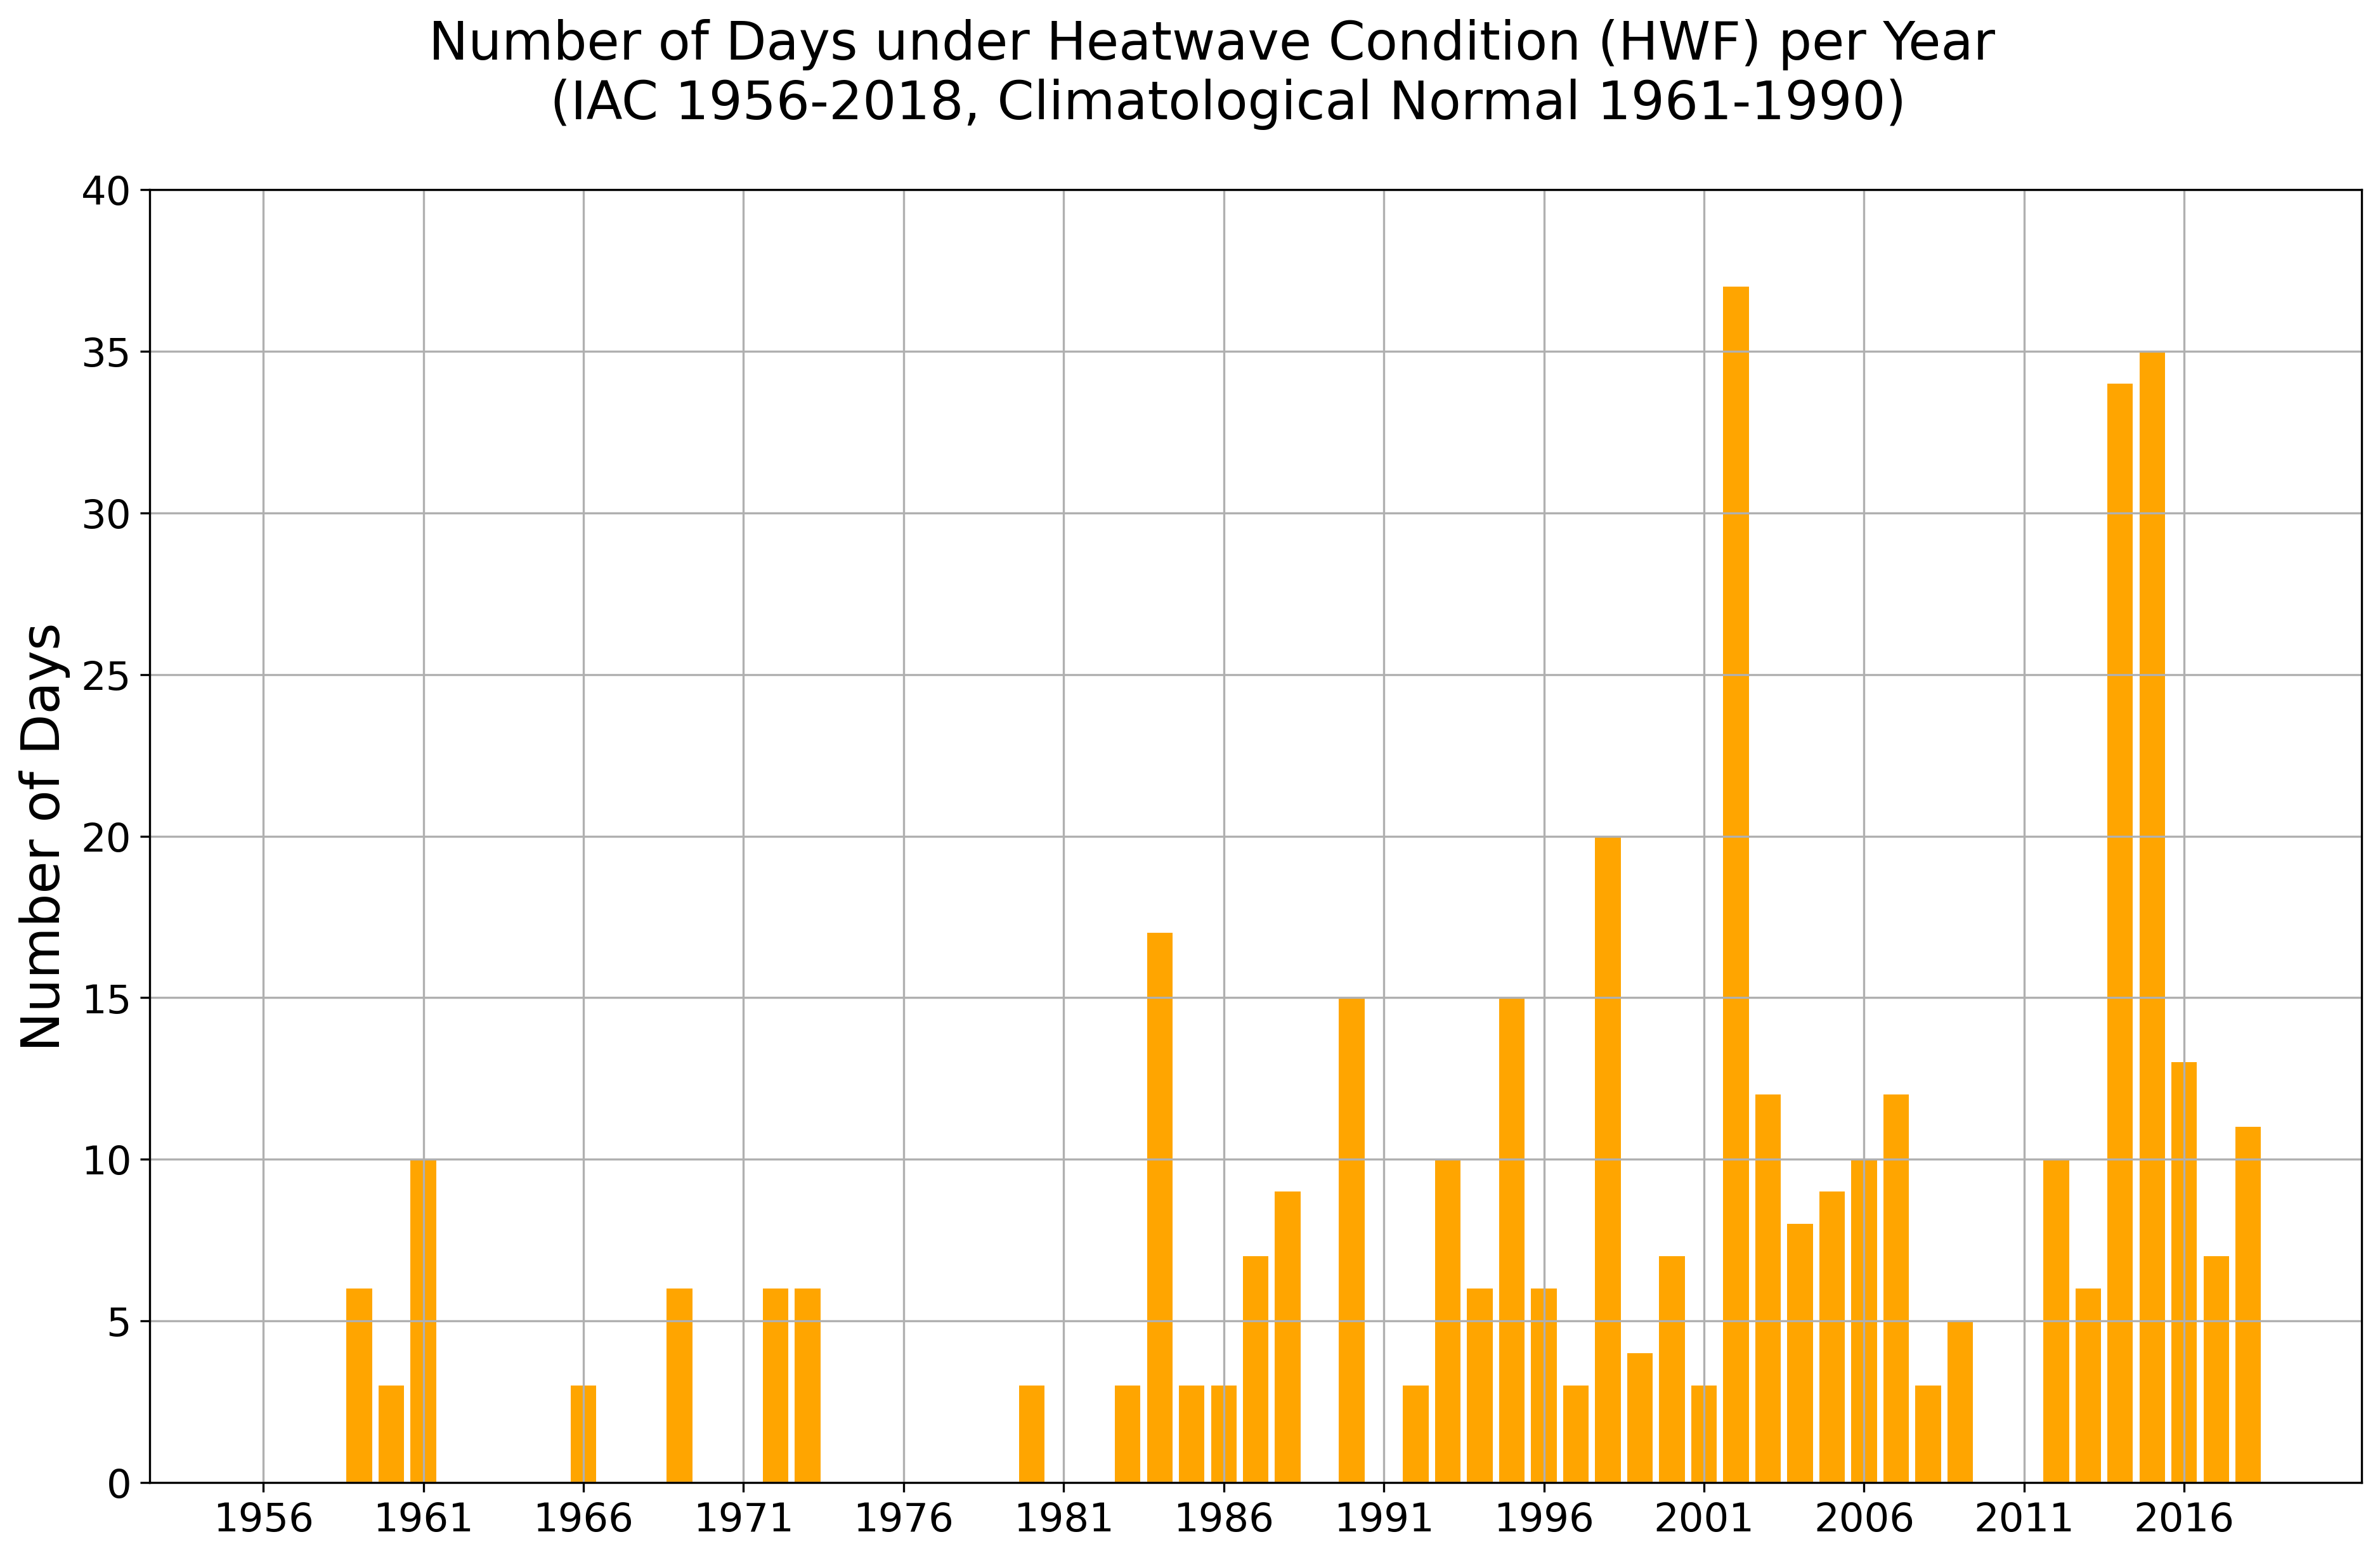

In [ ]:
tex.plot_oneMetric(HW_IAC_metrics,'HWF','Number of Days under Heatwave Condition (HWF) per Year \n (IAC 1956-2018, Climatological Normal 1961-1990)',lim=40)

#### Yearly metrics description

In [ ]:
#checking metrics value for whole database period
HW_IAC_metrics.sum()

HWN     98.0
HWD    186.0
HWF    389.0
dtype: float64

In [ ]:
HW_IAC_metrics.describe()

,HWN,HWD,HWF
count,63.000000,63.000000,63.000000
mean,1.555556,2.952381,6.174603
std,1.803024,2.892864,8.251177
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,3.000000,3.000000
75%,2.000000,4.000000,9.000000
max,8.000000,12.000000,37.000000


##### Metrics description according to 21 year sub-periods



###### 1956-1976

In [ ]:
#selecting period from 1956 to 1976
#checking metrics values
HW_IAC_metrics[(HW_IAC_metrics.index>=1956)&(HW_IAC_metrics.index<=1976)].sum()

HWN    12.0
HWD    25.0
HWF    40.0
dtype: float64

In [ ]:
#selecting period from 1956 to 1976
#checking descriptive statistics
HW_IAC_metrics[(HW_IAC_metrics.index>=1956)&(HW_IAC_metrics.index<=1976)].describe()

,HWN,HWD,HWF
count,21.000000,21.000000,21.000000
mean,0.571429,1.190476,1.904762
std,0.925820,1.833550,3.048028
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,3.000000,3.000000
max,3.000000,6.000000,10.000000


###### 1977-1997

In [ ]:
#selecting period from 1977 to 1997
#checking metrics values
HW_IAC_metrics[(HW_IAC_metrics.index>=1977)&(HW_IAC_metrics.index<=1997)].sum()

HWN     30.0
HWD     50.0
HWF    103.0
dtype: float64

In [ ]:
#selecting period from 1977 to 1997
#checking descriptive statistics
HW_IAC_metrics[(HW_IAC_metrics.index>=1977)&(HW_IAC_metrics.index<=1997)].describe()

,HWN,HWD,HWF
count,21.000000,21.000000,21.000000
mean,1.428571,2.380952,4.904762
std,1.502379,1.856777,5.430513
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,3.000000,3.000000
75%,2.000000,3.000000,7.000000
max,5.000000,5.000000,17.000000


###### 1998-2018

In [ ]:
#selecting period from 1998 to 2018
#checking metrics values
HW_IAC_metrics[(HW_IAC_metrics.index>=1998)&(HW_IAC_metrics.index<=2018)].sum()

HWN     56.0
HWD    111.0
HWF    246.0
dtype: float64

In [ ]:
#selecting period from 1998 to 2018
#checking descriptive statistics
HW_IAC_metrics[(HW_IAC_metrics.index>=1998)&(HW_IAC_metrics.index<=2018)].describe()

,HWN,HWD,HWF
count,21.000000,21.000000,21.000000
mean,2.666667,5.285714,11.714286
std,2.152518,3.132776,10.918529
min,0.000000,0.000000,0.000000
25%,1.000000,4.000000,5.000000
50%,2.000000,5.000000,9.000000
75%,3.000000,6.000000,12.000000
max,8.000000,12.000000,37.000000


### Seasonal Metrics

Function: *tex.wave_seasonMetrics*


In [ ]:
#checking wave_seasonMetrics parameters
help(tex.wave_seasonMetrics)

Help on function wave_seasonMetrics in module climatex:

wave_seasonMetrics(df_checkW, wave_column, plot=False)
    #-------------------------------------------------------------------------------
    ## Function to obtain the seasonal metrics of a Heat/Cold Wave given the
    ## database dataframe containing the 'HW'/'CW' column that indicates if a day is
    ## part of a Heat/Cold Wave or not (check get_wave function). This function
    ## obtains the number of HW/CW events (HWN/CWN), the event with maximum duration
    ## (HWD/CWD) and the cumulative sum of wave durations (HWF) for all seasons
    ## (summer, autumn, winter and spring) of each year of the dataframe. These
    ## metrics are stored in a dataframe which includes the Heat/Cold Wave metrics
    ## for each year of the database, separated by seasons.
    ##
    ## The calendar year adopted is from december of previous year until november of
    ## actual year.
    ##
    ## It is possible to plot the seasonal metrics, fo

In [ ]:
#obtaining seasonal metrics
HW_IAC_seasonMetrics = tex.wave_seasonMetrics(HW_IAC,'HW')

In [ ]:
HW_IAC_seasonMetrics

HWN  HWD  HWF
YEAR SEASON               
1956 1       0.0  0.0  0.0
     2       0.0  0.0  0.0
     3       0.0  0.0  0.0
     4       0.0  0.0  0.0
1957 1       0.0  0.0  0.0
...          ...  ...  ...
2017 4       1.0  4.0  4.0
2018 1       0.0  0.0  0.0
     2       0.0  0.0  0.0
     3       0.0  0.0  0.0
     4       1.0  3.0  3.0

[252 rows x 3 columns]

In [ ]:
#saving seasonal metrics dataframe locally
HW_IAC_seasonMetrics.to_csv('IAC_HW_seasonMetrics.csv')

#### Plotting metrics

Function: *tex.plot_seasonMetric*



In [ ]:
help(tex.plot_oneSeasonMetric)

Help on function plot_oneSeasonMetric in module climatex:

plot_oneSeasonMetric(df_seasonMetrics, metric, title, lim=None, y_interval=None)
    #-------------------------------------------------------------------------------
    ## Function that plots Heat/Cold yearly wave metric. It receives the yearly
    ## metrics dataframe and the metric to be plotted.
    ##
    ## :param      df_metrics:  Dataframe with yearly metrics ("HWN","HWD","HWF" or
    ##                          "CWN", "CWD","CWF")
    ## :type       df_metrics:  pandas.DataFrame
    ## :param      metric:      Name of the metric to be plotted (e.g. HWN)
    ## :type       metric:      String
    ## :param      title:       Title of the plot
    ## :type       title:       String
    ## :param      lim:         Upper limit of y axis
    ## :type       lim:         Float
    ## :param      x_interval:  Interval of x axis (years interval)
    ## :type       x_interval:  Integer
    ##
    ## :returns:   metric plot
    ##

##### HWN

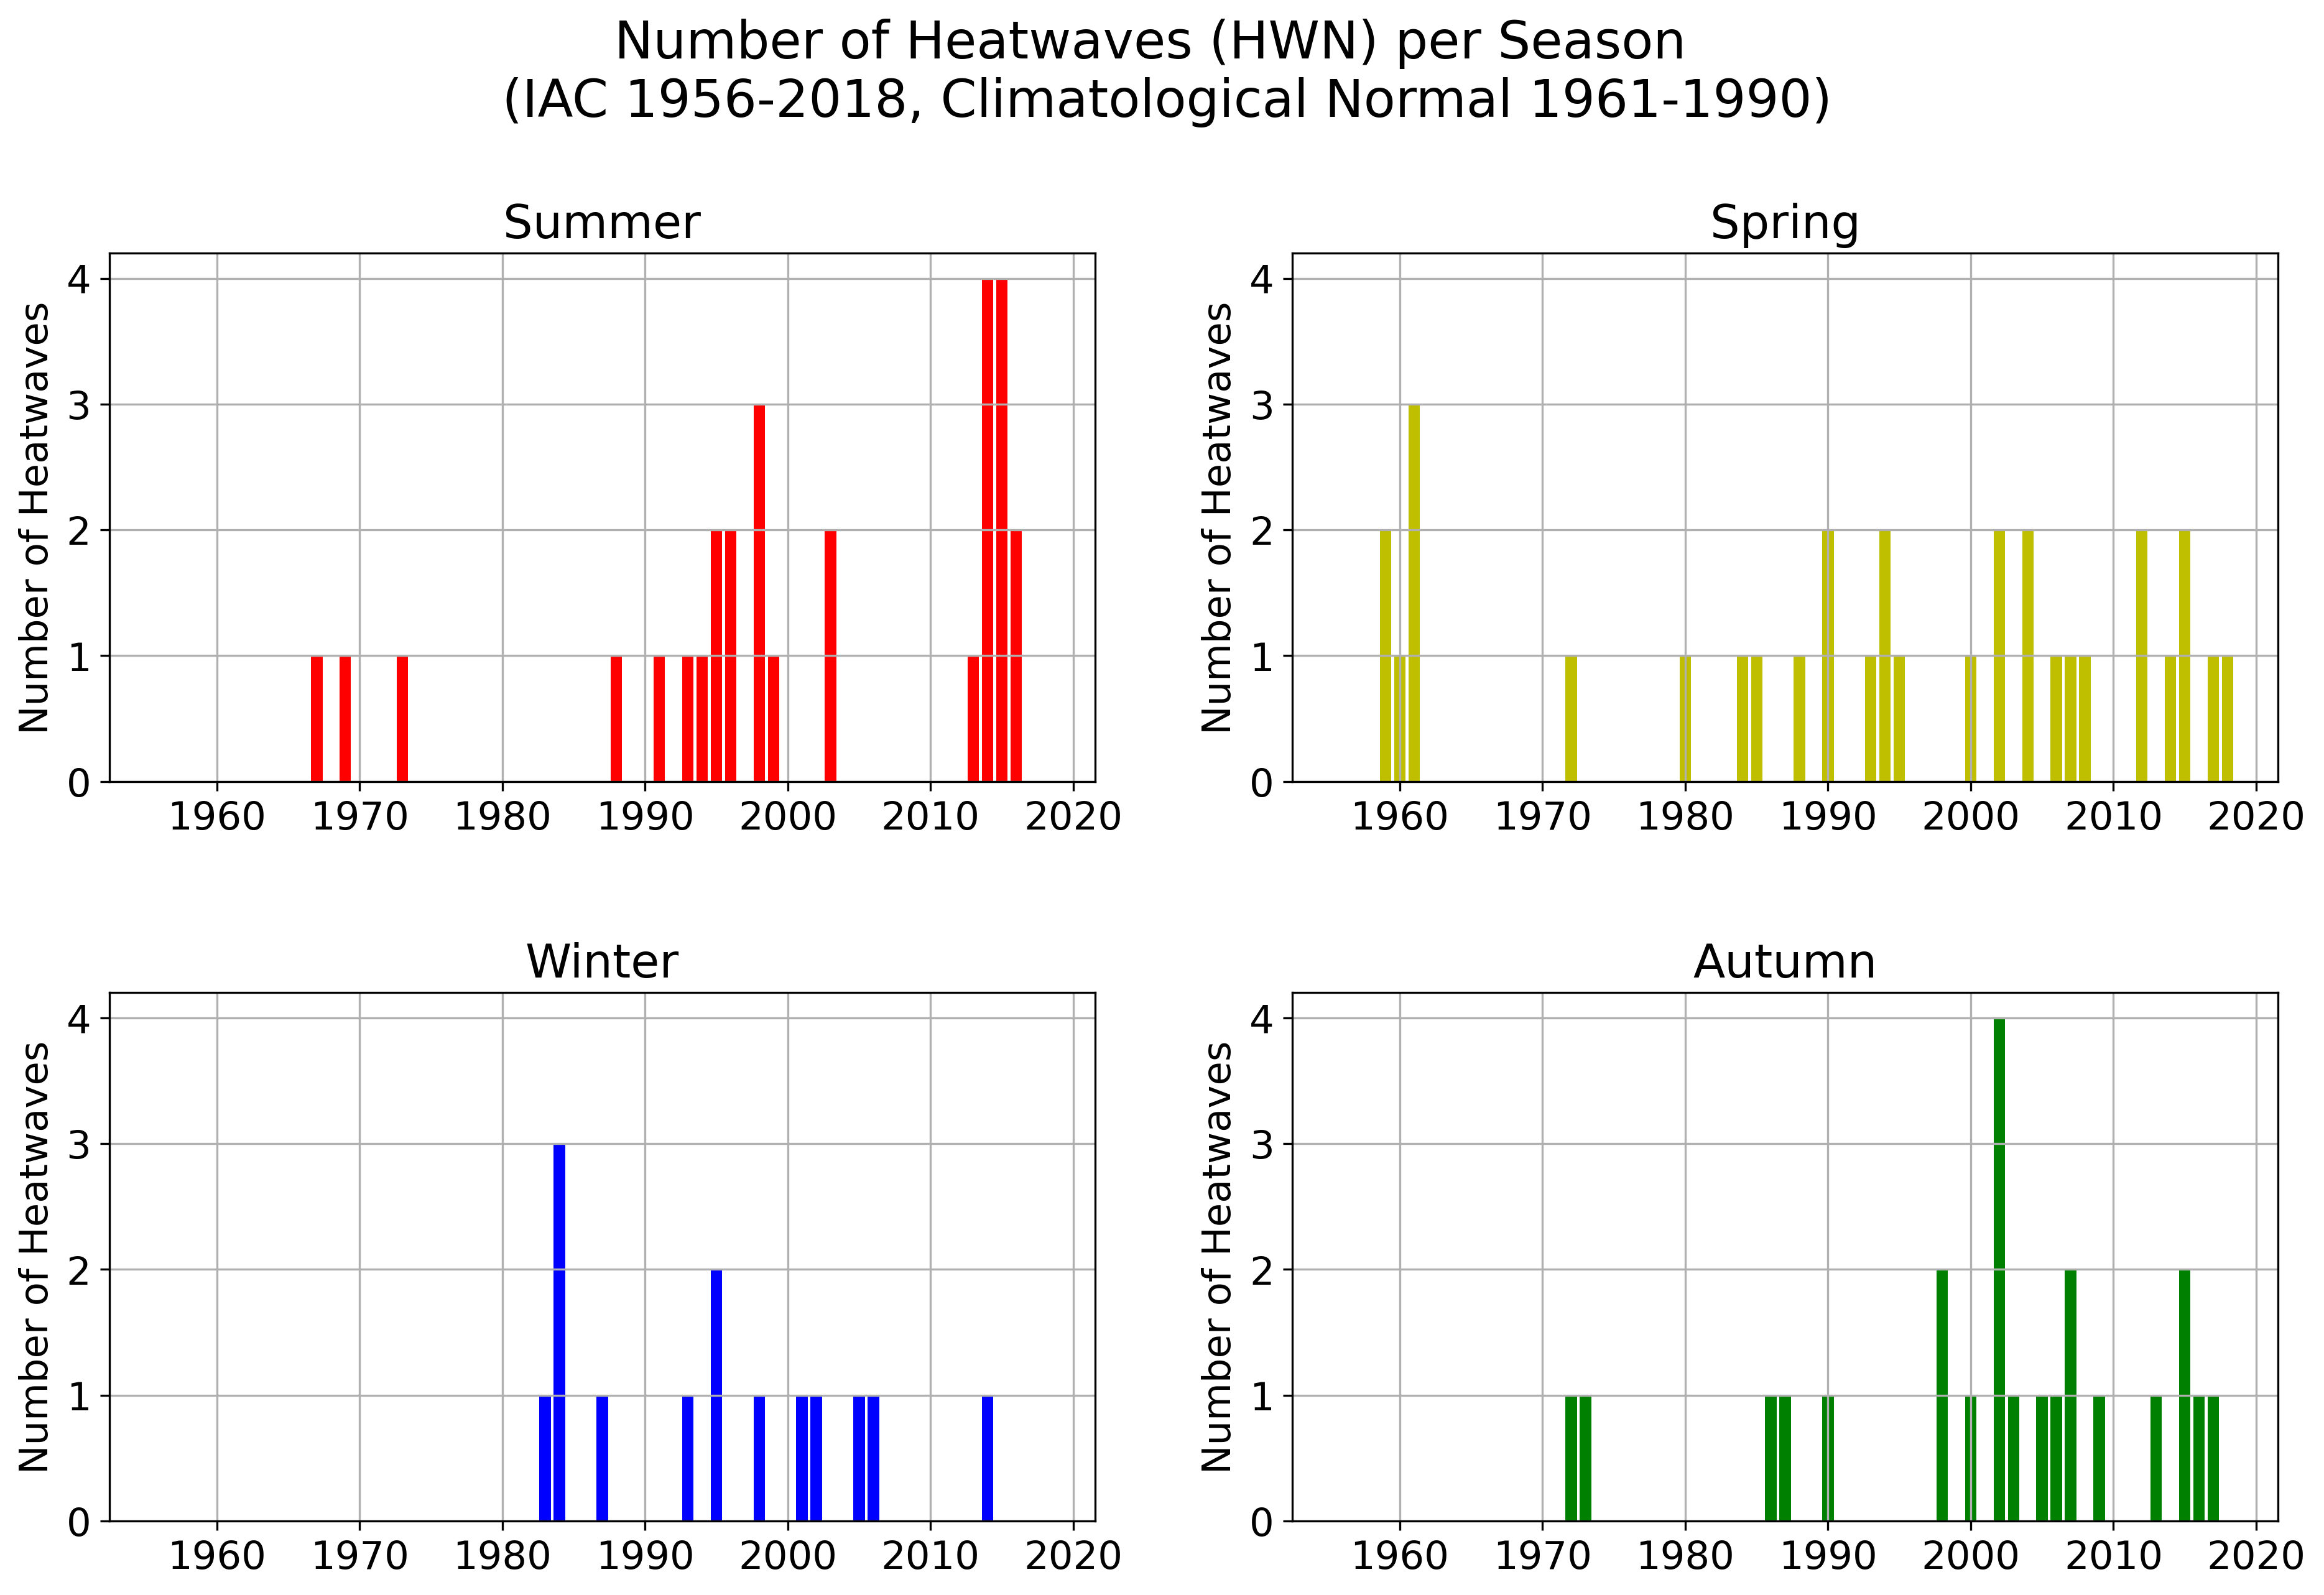

In [ ]:
tex.plot_oneSeasonMetric(HW_IAC_seasonMetrics,'HWN','Number of Heatwaves (HWN) per Season \n (IAC 1956-2018, Climatological Normal 1961-1990)',lim=4.2)

##### HWD

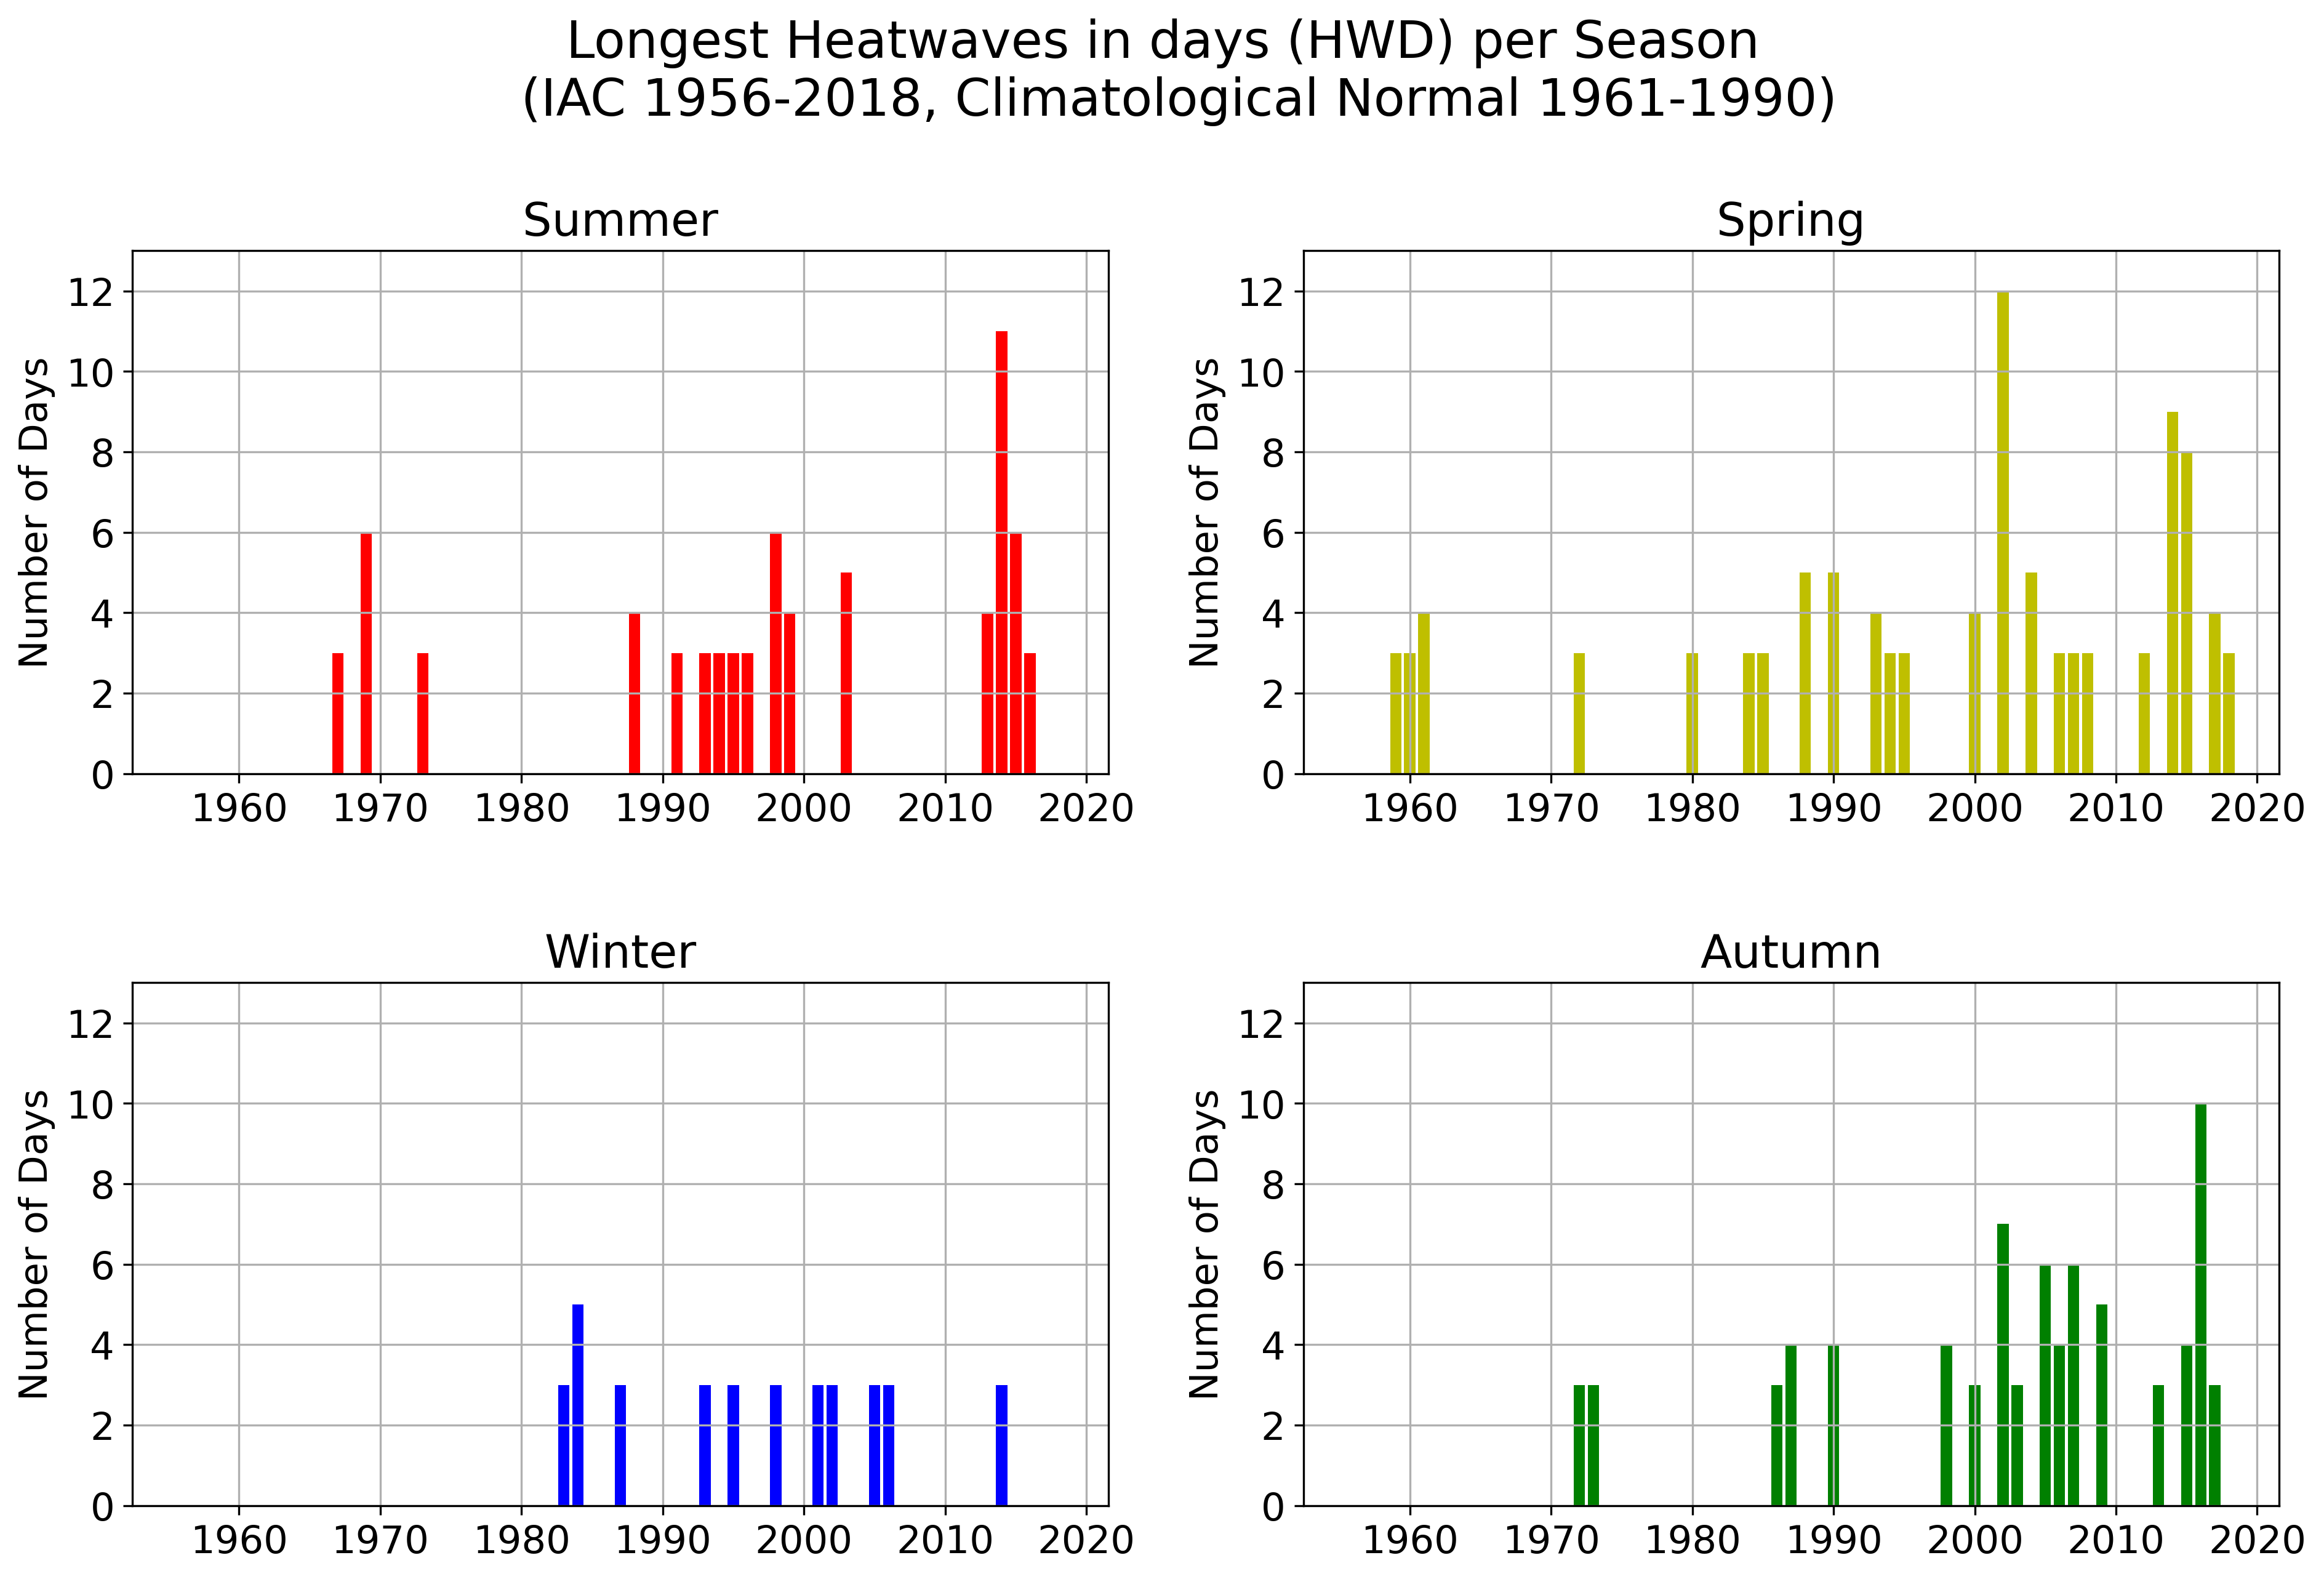

In [ ]:
tex.plot_oneSeasonMetric(HW_IAC_seasonMetrics,'HWD','Longest Heatwaves in days (HWD) per Season \n (IAC 1956-2018, Climatological Normal 1961-1990)',lim=13,y_interval=2)

##### HWF

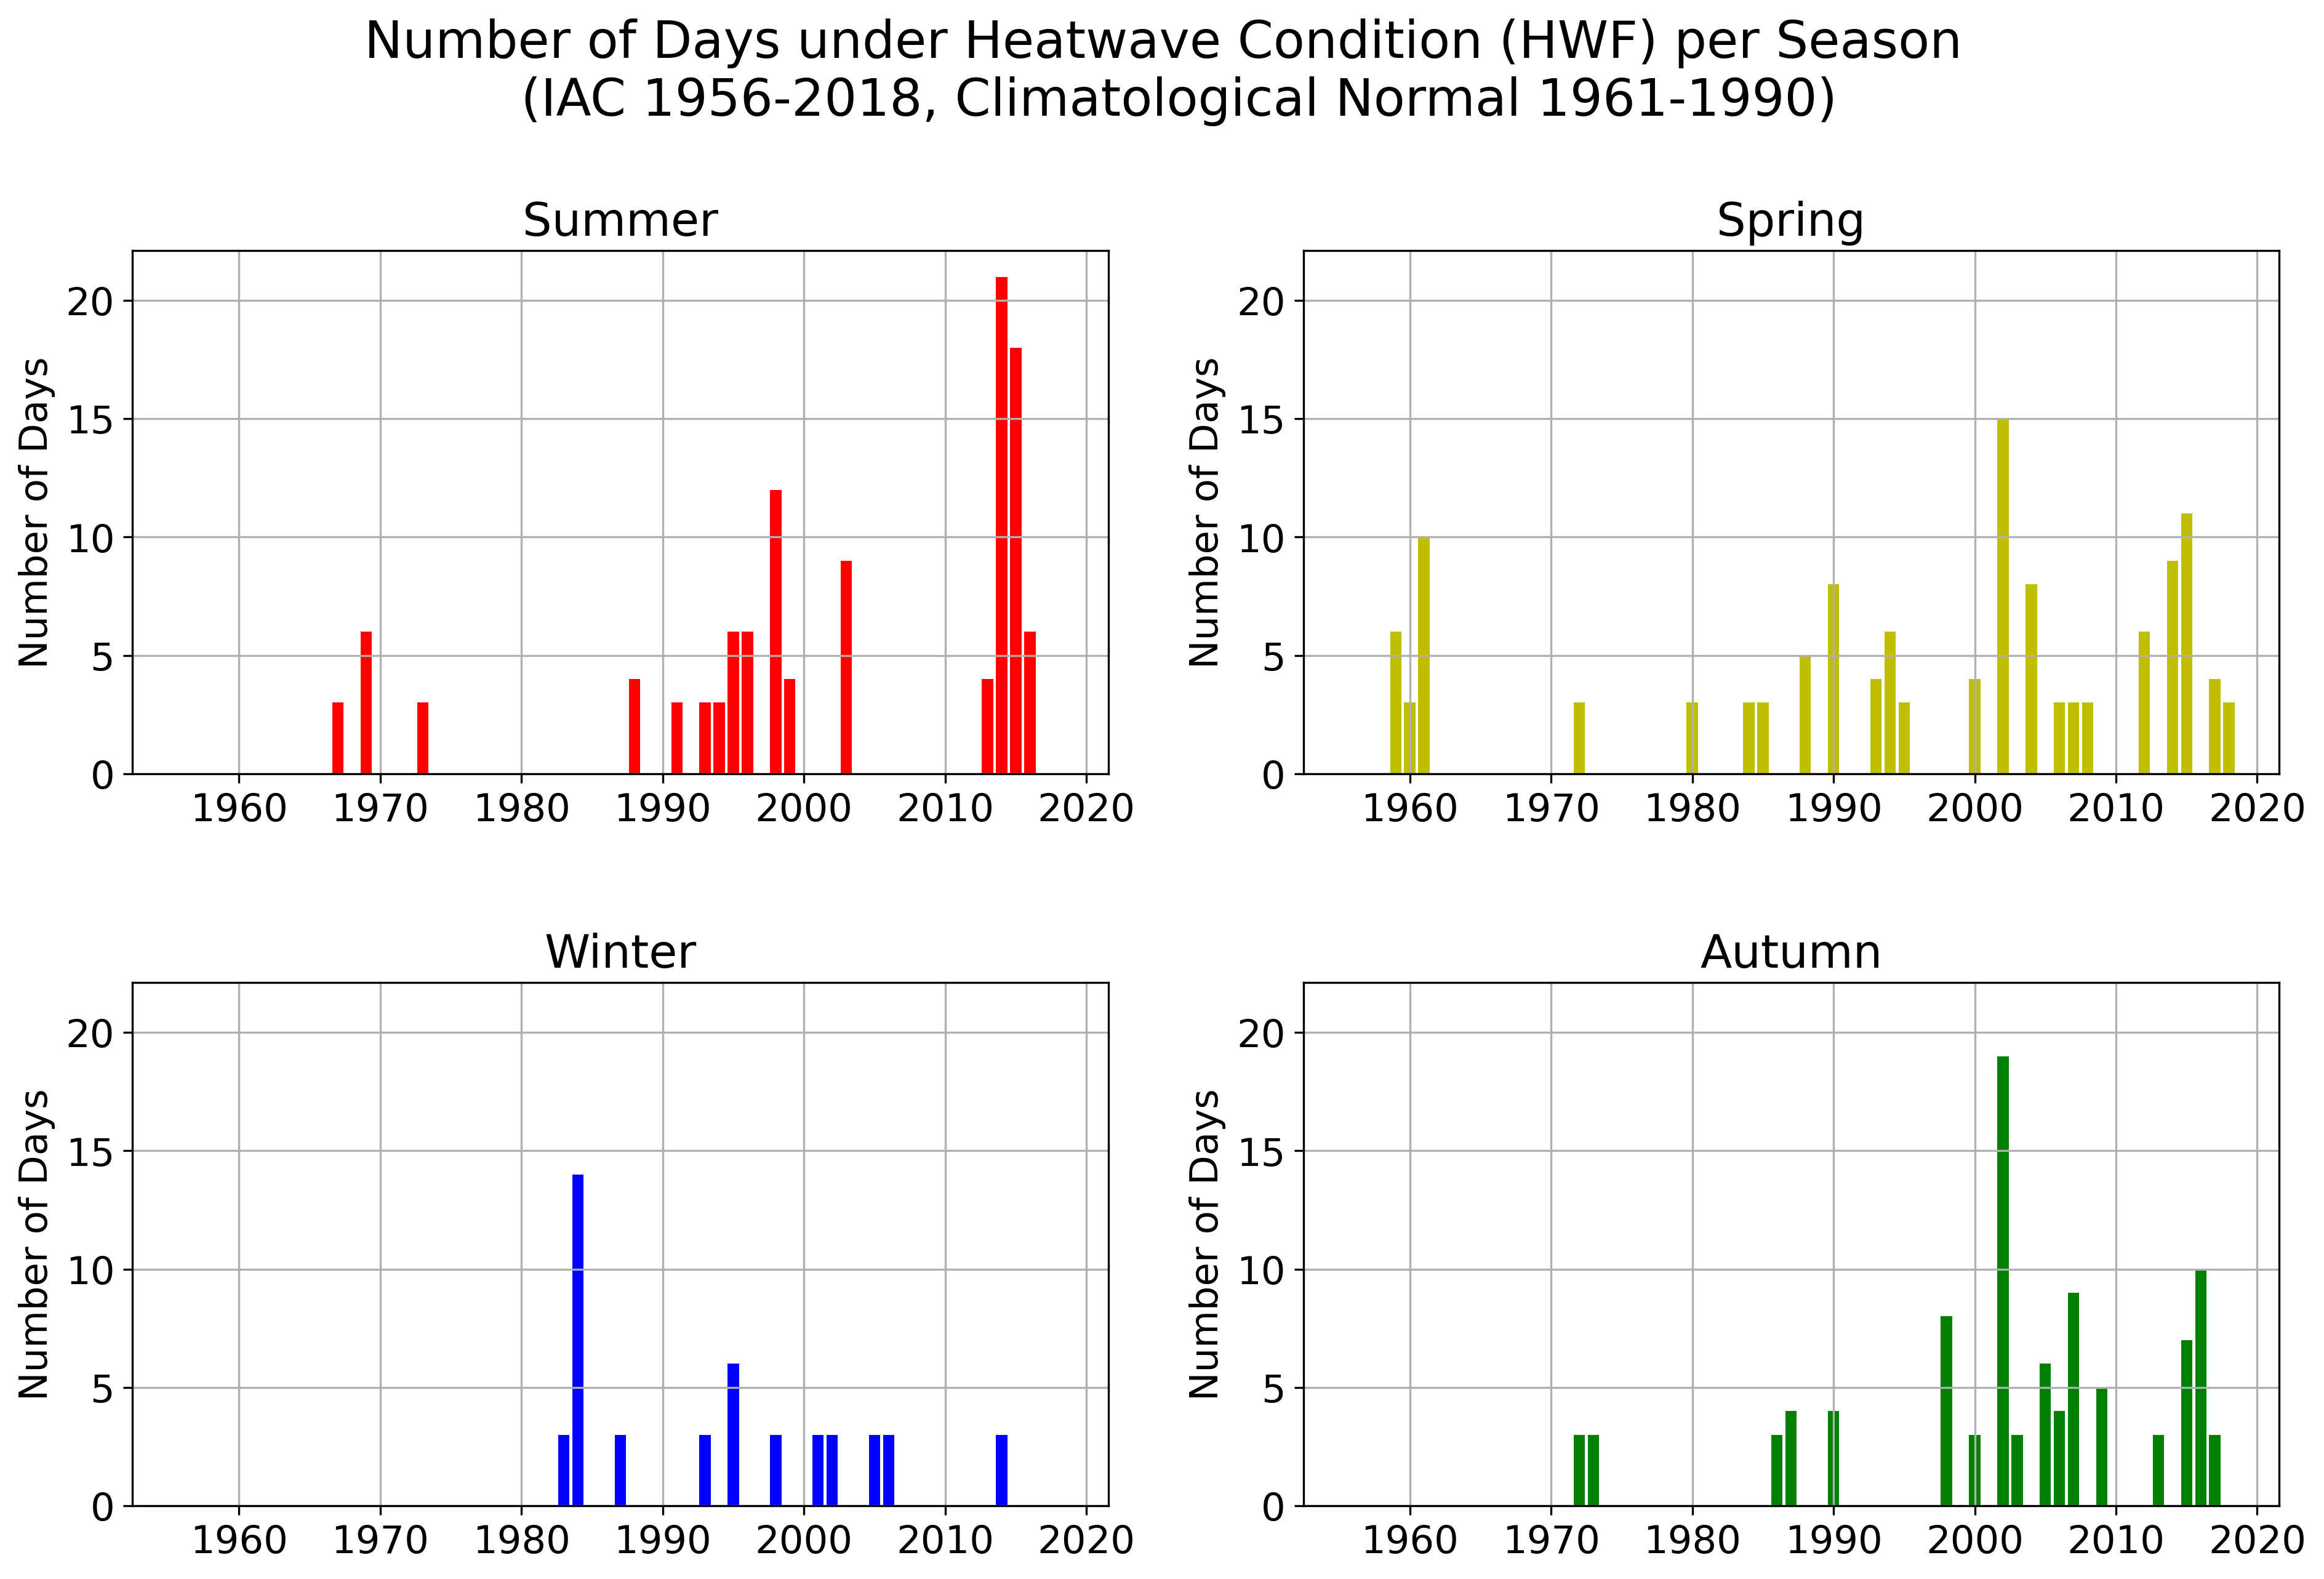

In [ ]:
tex.plot_oneSeasonMetric(HW_IAC_seasonMetrics,'HWF','Number of Days under Heatwave Condition (HWF) per Season \n (IAC 1956-2018, Climatological Normal 1961-1990)',lim=22.1)


#### Seasonal metrics description

In [ ]:
#checking metrics value for whole database period
HW_IAC_seasonMetrics.sum()

HWN     97.0
HWD    279.0
HWF    381.0
dtype: float64

##### *Summer*



In [ ]:
#checking metrics values for summer
HW_IAC_seasonMetrics.xs('1', level=1).sum()

HWN     28.0
HWD     70.0
HWF    111.0
dtype: float64

###### Metrics description according to 21 year sub-periods

###### 1956-1976

In [ ]:
HW_IAC_seasonMetrics.xs('1', level=1)[((HW_IAC_seasonMetrics.xs('1', level=1).index>=1956)&(HW_IAC_seasonMetrics.xs('1', level=1).index<=1976))].sum()

HWN     3.0
HWD    12.0
HWF    12.0
dtype: float64

###### 1977-1997

In [ ]:
HW_IAC_seasonMetrics.xs('1', level=1)[((HW_IAC_seasonMetrics.xs('1', level=1).index>=1977)&(HW_IAC_seasonMetrics.xs('1', level=1).index<=1997))].sum()

HWN     8.0
HWD    19.0
HWF    25.0
dtype: float64

###### 1998-2018

In [ ]:
HW_IAC_seasonMetrics.xs('1', level=1)[((HW_IAC_seasonMetrics.xs('1', level=1).index>=1998)&(HW_IAC_seasonMetrics.xs('1', level=1).index<=2018))].sum()

HWN    17.0
HWD    39.0
HWF    74.0
dtype: float64

##### *Autumn*



In [ ]:
#checking metrics values for autumn
HW_IAC_seasonMetrics.xs('2', level=1).sum()

HWN    23.0
HWD    75.0
HWF    97.0
dtype: float64

###### Metrics description according to 21 year sub-periods

###### 1956-1976

In [ ]:
HW_IAC_seasonMetrics.xs('2', level=1)[((HW_IAC_seasonMetrics.xs('2', level=1).index>=1956)&(HW_IAC_seasonMetrics.xs('2', level=1).index<=1976))].sum()

HWN    2.0
HWD    6.0
HWF    6.0
dtype: float64

###### 1977-1997

In [ ]:
HW_IAC_seasonMetrics.xs('2', level=1)[((HW_IAC_seasonMetrics.xs('2', level=1).index>=1977)&(HW_IAC_seasonMetrics.xs('2', level=1).index<=1997))].sum()

HWN     3.0
HWD    11.0
HWF    11.0
dtype: float64

###### 1998-2018

In [ ]:
HW_IAC_seasonMetrics.xs('2', level=1)[((HW_IAC_seasonMetrics.xs('2', level=1).index>=1998)&(HW_IAC_seasonMetrics.xs('2', level=1).index<=2018))].sum()

HWN    18.0
HWD    58.0
HWF    80.0
dtype: float64

##### *Winter*



In [ ]:
#checking metrics values for winter
HW_IAC_seasonMetrics.xs('3', level=1).sum()

HWN    14.0
HWD    35.0
HWF    47.0
dtype: float64

###### Metrics description according to 21 year sub-periods

###### 1956-1976



In [ ]:
HW_IAC_seasonMetrics.xs('3', level=1)[((HW_IAC_seasonMetrics.xs('3', level=1).index>=1956)&(HW_IAC_seasonMetrics.xs('3', level=1).index<=1976))].sum()

HWN    0.0
HWD    0.0
HWF    0.0
dtype: float64

###### 1977-1997

In [ ]:
HW_IAC_seasonMetrics.xs('3', level=1)[((HW_IAC_seasonMetrics.xs('3', level=1).index>=1977)&(HW_IAC_seasonMetrics.xs('3', level=1).index<=1997))].sum()

HWN     8.0
HWD    17.0
HWF    29.0
dtype: float64

###### 1998-2018

In [ ]:
HW_IAC_seasonMetrics.xs('3', level=1)[((HW_IAC_seasonMetrics.xs('3', level=1).index>=1998)&(HW_IAC_seasonMetrics.xs('3', level=1).index<=2018))].sum()

HWN     6.0
HWD    18.0
HWF    18.0
dtype: float64

##### *Spring*



In [ ]:
#checking metrics values for spring
HW_IAC_seasonMetrics.xs('4', level=1).sum()

HWN     32.0
HWD     99.0
HWF    126.0
dtype: float64

###### Metrics description according to 21 year sub-periods

###### 1956-1976

In [ ]:
HW_IAC_seasonMetrics.xs('4', level=1)[((HW_IAC_seasonMetrics.xs('4', level=1).index>=1956)&(HW_IAC_seasonMetrics.xs('4', level=1).index<=1976))].sum()

HWN     7.0
HWD    13.0
HWF    22.0
dtype: float64

###### 1977-1997

In [ ]:
HW_IAC_seasonMetrics.xs('4', level=1)[((HW_IAC_seasonMetrics.xs('4', level=1).index>=1977)&(HW_IAC_seasonMetrics.xs('4', level=1).index<=1997))].sum()

HWN    10.0
HWD    29.0
HWF    35.0
dtype: float64

###### 1998-2018

In [ ]:
HW_IAC_seasonMetrics.xs('4', level=1)[((HW_IAC_seasonMetrics.xs('4', level=1).index>=1998)&(HW_IAC_seasonMetrics.xs('4', level=1).index<=2018))].sum()

HWN    15.0
HWD    57.0
HWF    69.0
dtype: float64

## **Trend Analysis:** Yearly Metrics

### Autocorrrelation

Obtaining the autocorrelation for all metrics


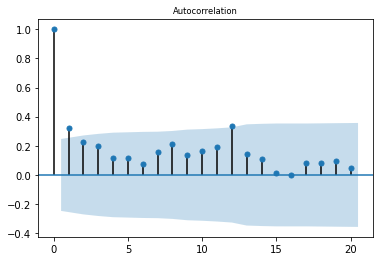

In [ ]:
plot_acf(HW_IAC_metrics['HWN'], lags=20)
plt.show()

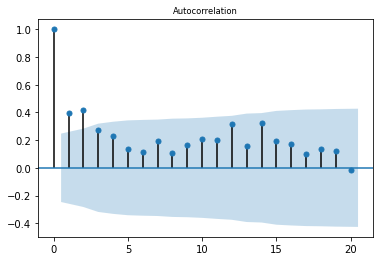

In [ ]:
plot_acf(HW_IAC_metrics['HWD'], lags=20)
plt.show()

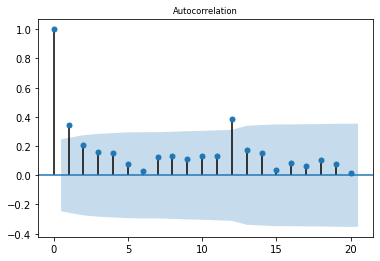

In [ ]:
plot_acf(HW_IAC_metrics['HWF'], lags=20)
plt.show()

In [ ]:
acf(HW_IAC_metrics['HWN'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.31875536,  0.22295725,  0.19661889,  0.11294867,
        0.11527625,  0.07736126,  0.15796888,  0.21542325,  0.1339581 ,
        0.16440034,  0.19263751,  0.33774348,  0.14051207,  0.11196864,
        0.01617053, -0.00245008,  0.07981134,  0.08103638,  0.09438932,
        0.05041039, -0.0321573 ,  0.03797623, -0.0677447 , -0.09077545,
       -0.03497489, -0.13793948, -0.11742007, -0.12666912, -0.01739557,
       -0.04649026, -0.04030381, -0.13555066, -0.14424844, -0.08403773,
       -0.13352934, -0.16758545, -0.17187309, -0.22522357, -0.16942301,
       -0.1676467 ])

In [ ]:
acf(HW_IAC_metrics['HWD'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.39463586,  0.41987011,  0.27302287,  0.23208604,
        0.13883645,  0.11368523,  0.19673886,  0.10862877,  0.16506713,
        0.21141004,  0.19791448,  0.3174035 ,  0.1537611 ,  0.32280959,
        0.19376704,  0.17265401,  0.09858576,  0.13520034,  0.11996102,
       -0.01669901,  0.010279  , -0.02606898, -0.13372754, -0.05636407,
       -0.1411702 , -0.09088088, -0.15421124, -0.0961209 , -0.02518181,
       -0.04611129, -0.08677278, -0.09852458, -0.04282043, -0.11964198,
       -0.16819628, -0.14479757, -0.23703762, -0.21180337, -0.24071743,
       -0.23080991])

In [ ]:
acf(HW_IAC_metrics['HWF'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.34229972,  0.2063384 ,  0.15614842,  0.1544979 ,
        0.07663502,  0.03130726,  0.12384764,  0.13495245,  0.11265348,
        0.12965086,  0.13247523,  0.38264099,  0.17075687,  0.15500102,
        0.0392181 ,  0.08635522,  0.06346586,  0.10645148,  0.07401819,
        0.01729636, -0.01317775, -0.00810841, -0.07303922, -0.05776035,
       -0.0401237 , -0.08783181, -0.08963275, -0.09711944, -0.02949181,
        0.00187412, -0.02371898, -0.11319402, -0.11272743, -0.09415444,
       -0.1362144 , -0.14938684, -0.15355684, -0.18231245, -0.16396508,
       -0.16906014])

### Mann-Kendall

Performing Mann-Kendall trend test


In [ ]:
#loading metrics data in R
%%R
HW_metricsR  = read.csv('/content/IAC_HWmetrics.csv')

In [ ]:
%%R
print(head(HW_metricsR))

  YEAR HWN HWD HWF
1 1956   0   0   0
2 1957   0   0   0
3 1958   0   0   0
4 1959   2   3   6
5 1960   1   3   3
6 1961   3   4  10



#### HWN


In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(HW_metricsR$HWN)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
4.354529e+00 3.571429e-02 7.080000e+02 2.636067e+04 1.333531e-05 3.625192e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(HW_metricsR$HWN)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   4.598165e+00    3.443448e-02    3.571429e-02    4.262289e-06    7.580000e+02 
         Var(S)             Tau 
   2.710333e+04    4.008461e-01 


#### HWD


In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(HW_metricsR$HWD)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
5.013109e+00 8.333333e-02 8.140000e+02 2.630067e+04 5.355747e-07 4.167947e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(HW_metricsR$HWD)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   5.199414e+00    8.597980e-02    8.333333e-02    1.999178e-07    8.570000e+02 
         Var(S)             Tau 
   2.710433e+04    4.531994e-01 


#### HWF


In [ ]:
#applying original Mann-Kendall test
%%R
mkttest(HW_metricsR$HWF)

     Z-Value  Sen's slope            S       Var(S)      P-value          Tau 
4.696656e+00 1.428571e-01 7.700000e+02 2.680867e+04 2.644556e-06 3.942652e-01 


In [ ]:
#applying trend-free pre-whitening modified Mann-Kendall test
%%R
tfpwmk(HW_metricsR$HWF)

        Z-Value     Sen's Slope Old Sen's Slope         P-value               S 
   4.701339e+00    1.403983e-01    1.428571e-01    2.584606e-06    7.750000e+02 
         Var(S)             Tau 
   2.710433e+04    4.098361e-01 


### Pettitt Test

Performing homogeneity test

In [ ]:
#HWN
%%R
pettitt.test(HW_metricsR$HWN)


	Pettitt's test for single change-point detection

data:  HW_metricsR$HWN
U* = 668, p-value = 5.291e-05
alternative hypothesis: two.sided
sample estimates:
probable change point at time K 
                             28 



In [ ]:
#HWD
%%R
pettitt.test(HW_metricsR$HWD)


	Pettitt's test for single change-point detection

data:  HW_metricsR$HWD
U* = 686, p-value = 2.975e-05
alternative hypothesis: two.sided
sample estimates:
probable change point at time K                            <NA> 
                             27                              28 



In [ ]:
#HWN
%%R
pettitt.test(HW_metricsR$HWF)


	Pettitt's test for single change-point detection

data:  HW_metricsR$HWF
U* = 695, p-value = 2.218e-05
alternative hypothesis: two.sided
sample estimates:
probable change point at time K 
                             28 



In [ ]:
#change point
cp = 1956 + 28 - 1
print(cp)

1983


## **Trend Analysis:** Seasonal Metrics

### Mann-Kendall

Performing Mann-Kendall trend test


#### *Summer*



##### HWN

In [ ]:
#applying original Mann-Kendall test
result1 = mk.original_test(HW_IAC_seasonMetrics['HWD'].xs('1', level=1))
print(result1)

Mann_Kendall_Test(trend='increasing', h=True, p=0.02239854506037564, z=2.2835405848711328, Tau=0.15053763440860216, s=294.0, var_s=16463.333333333332, slope=0.0, intercept=0.0)


##### HWD

In [ ]:
result2 = mk.original_test(HW_IAC_seasonMetrics['HWD'].xs('1', level=1))
print(result2)


Mann_Kendall_Test(trend='increasing', h=True, p=0.02239854506037564, z=2.2835405848711328, Tau=0.15053763440860216, s=294.0, var_s=16463.333333333332, slope=0.0, intercept=0.0)


##### HWF

In [ ]:
result3 = mk.original_test(HW_IAC_seasonMetrics['HWF'].xs('1', level=1))
print(result3)


Mann_Kendall_Test(trend='increasing', h=True, p=0.01331982492668149, z=2.4751016765381895, Tau=0.1633384536610343, s=319.0, var_s=16507.0, slope=0.0, intercept=0.0)


#### *Autumn*



##### HWN

In [ ]:
result1 = mk.original_test(HW_IAC_seasonMetrics['HWN'].xs('2', level=1))
print(result1)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0005902907060053586, z=3.436036836837007, Tau=0.22990271377368152, s=449.0, var_s=16999.666666666668, slope=0.0, intercept=0.0)


##### HWD

In [ ]:
result2 = mk.original_test(HW_IAC_seasonMetrics['HWD'].xs('2', level=1))
print(result2)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0003303003846728547, z=3.590297791769525, Tau=0.2416794674859191, s=472.0, var_s=17210.0, slope=0.0, intercept=0.0)


##### HWF

In [ ]:
result3 = mk.original_test(HW_IAC_seasonMetrics['HWF'].xs('2', level=1))
print(result3)

Mann_Kendall_Test(trend='increasing', h=True, p=0.00031326346861160204, z=3.6040775921576125, Tau=0.24270353302611367, s=474.0, var_s=17224.0, slope=0.0, intercept=0.0)


#### *Winter*



##### HWN

In [ ]:
result1 = mk.original_test(HW_IAC_seasonMetrics['HWN'].xs('3', level=1))
print(result1)

Mann_Kendall_Test(trend='no trend', h=False, p=0.058041812046190744, z=1.8953819968266812, Tau=0.1080389144905274, s=211.0, var_s=12275.666666666666, slope=0.0, intercept=0.0)


##### HWD

In [ ]:
result2 = mk.original_test(HW_IAC_seasonMetrics['HWD'].xs('3', level=1))
print(result2)

Mann_Kendall_Test(trend='no trend', h=False, p=0.054223337939712346, z=1.9250481243295023, Tau=0.10957501280081926, s=214.0, var_s=12242.666666666666, slope=0.0, intercept=0.0)


##### HWF

In [ ]:
result3 = mk.original_test(HW_IAC_seasonMetrics['HWF'].xs('3', level=1))
print(result3)

Mann_Kendall_Test(trend='no trend', h=False, p=0.058041812046190744, z=1.8953819968266812, Tau=0.1080389144905274, s=211.0, var_s=12275.666666666666, slope=0.0, intercept=0.0)


#### *Spring*



##### HWN

In [ ]:
result1 = mk.original_test(HW_IAC_seasonMetrics['HWN'].xs('4', level=1))
print(result1)

Mann_Kendall_Test(trend='increasing', h=True, p=0.02871810121295515, z=2.1873346744423654, Tau=0.16129032258064516, s=315.0, var_s=20607.666666666668, slope=0.0, intercept=0.0)


##### HWD

In [ ]:
result2 = mk.original_test(HW_IAC_seasonMetrics['HWD'].xs('4', level=1))
print(result2)

Mann_Kendall_Test(trend='increasing', h=True, p=0.011795515462416528, z=2.5182034818551626, Tau=0.1863799283154122, s=364.0, var_s=20779.333333333332, slope=0.0, intercept=0.0)


##### HWF

In [ ]:
result3 = mk.original_test(HW_IAC_seasonMetrics['HWF'].xs('4', level=1))
print(result3)

Mann_Kendall_Test(trend='increasing', h=True, p=0.015544496156964405, z=2.4194383328406, Tau=0.17972350230414746, s=351.0, var_s=20927.0, slope=0.0, intercept=0.0)


## **Heatwave Amplitude/Intensity**

Function: *tex.wave_intensity*

Calling tex.wave_intensity to obtain a dataframe with **Tmax anomaly** according to seasonal calendar

- Tmax anomaly is calculated subtracting the respective CTX90pct from the maximum temperature of a Heatwave


In [ ]:
help(tex.wave_intensity)

Help on function wave_intensity in module climatex:

wave_intensity(df_checkW, wave_column, db_columnMAX, df_pct, season=False)
    #-------------------------------------------------------------------------------
    ## Function that generates a dataframe with the Tmax anomaly of each Heat/Cold
    ## wave (maximum temperature of each HW minus the correspondent CTX90pct - according to day
    ## of the year - DAY365)
    ##
    ## :param      df_checkW:     Database dataframe with the column "HW" or CW"
    ## :type       df_checkW:     pandas.DataFrame
    ## :param      wave_column:   Name of the column with information about
    ##                            Heat/Cold Waves (e.g. 'HW' or 'CW')
    ## :type       wave_column:   String
    ## :param      db_columnMAX:  Name of the column of the database with daily maximum
    ##                            temperatures to be compared with CTX_pct
    ## :type       db_columnMAX:  String
    ## :param      df_pct:        The df pct - da

In [ ]:
HW_IAC_intensity = tex.wave_intensity(HW_IAC,'HW','N_AIRTMP_MAX',pct_IAC,season=True)

In [ ]:
HW_IAC_intensity

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
0,251,1959-09-08,35.5,33.00,2.50,4
1,276,1959-10-03,36.4,32.62,3.78,4
2,279,1960-10-06,34.7,32.60,2.10,4
3,257,1961-09-14,36.6,33.20,3.40,4
4,263,1961-09-20,37.2,33.40,3.80,4
...,...,...,...,...,...,...
92,147,2015-05-27,29.6,28.00,1.60,2
93,262,2015-09-19,35.4,33.40,2.00,4
94,315,2015-11-11,33.7,32.16,1.54,4
95,9,2016-01-09,34.4,32.31,2.09,1


### Checking Heatwave Intensity according to each season

#### *Summer*



In [ ]:
#selecting summer heatwaves
df_summer = HW_IAC_intensity[HW_IAC_intensity['season']=='1']
df_summer

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
6,346,1967-12-12,34.1,32.10,2.00,1
7,7,1969-01-07,34.6,32.20,2.40,1
11,53,1973-02-22,33.6,32.60,1.00,1
27,20,1988-01-20,34.8,32.81,1.99,1
32,336,1991-12-02,34.4,32.60,1.80,1
33,1,1993-01-01,34.4,31.40,3.00,1
34,1,1998-01-01,33.4,31.40,2.00,1
38,337,1994-12-03,33.6,32.60,1.00,1
41,16,1995-01-16,33.8,32.80,1.00,1
42,57,1995-02-26,33.6,32.50,1.10,1


##### Dividing temperatures according to 21 year sub-periods


###### 1956-1976

In [ ]:
df_summer[(df_summer.DATE.dt.year >= 1956) & (df_summer.DATE.dt.year <= 1976)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
6,346,1967-12-12,34.1,32.1,2.0,1
7,7,1969-01-07,34.6,32.2,2.4,1
11,53,1973-02-22,33.6,32.6,1.0,1


###### 1977-1997

In [ ]:
df_summer[(df_summer.DATE.dt.year >= 1977) & (df_summer.DATE.dt.year <= 1997)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
27,20,1988-01-20,34.8,32.81,1.99,1
32,336,1991-12-02,34.4,32.60,1.80,1
33,1,1993-01-01,34.4,31.40,3.00,1
38,337,1994-12-03,33.6,32.60,1.00,1
41,16,1995-01-16,33.8,32.80,1.00,1
42,57,1995-02-26,33.6,32.50,1.10,1
48,24,1996-01-24,33.8,32.80,1.00,1
49,29,1996-01-29,34.0,32.80,1.20,1


###### 1998-2018

In [ ]:
#amplitude of less than 2°C
df_summer[(df_summer.DATE.dt.year >= 1998) & (df_summer.DATE.dt.year <= 2018) & (df_summer['Tmax_anomaly'] <=2)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
34,1,1998-01-01,33.4,31.40,2.00,1
43,57,2003-02-26,33.6,32.50,1.10,1
50,361,1998-12-27,32.8,31.20,1.60,1
53,33,1998-02-02,33.8,32.80,1.00,1
56,21,1999-01-21,34.4,32.91,1.49,1
66,43,2003-02-12,33.8,32.60,1.20,1
81,343,2013-12-09,33.9,32.07,1.83,1
85,10,2014-01-10,33.7,32.40,1.30,1
88,3,2015-01-03,32.7,31.60,1.10,1


In [ ]:
#amplitude between 2-4°C
df_summer[(df_summer.DATE.dt.year >= 1998) & (df_summer.DATE.dt.year <= 2018) & (df_summer['Tmax_anomaly'] >2) & ((df_summer['Tmax_anomaly'] <=4))]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
51,361,2015-12-27,34.6,31.20,3.40,1
52,361,2016-12-27,34.6,31.20,3.40,1
84,5,2014-01-05,34.5,31.80,2.70,1
86,37,2014-02-06,36.6,32.60,4.00,1
89,12,2015-01-12,35.1,32.70,2.40,1
90,19,2015-01-19,36.4,32.91,3.49,1
95,9,2016-01-09,34.4,32.31,2.09,1


In [ ]:
#amplitude above 4°C
df_summer[(df_summer.DATE.dt.year >= 1998) & (df_summer.DATE.dt.year <= 2018) & (df_summer['Tmax_anomaly'] > 4)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
83,362,2014-12-28,36.1,31.2,4.9,1


#### *Autumn*



In [ ]:
#selecting autumn heatwaves
df_autumn = HW_IAC_intensity[HW_IAC_intensity['season']=='2']
df_autumn

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
8,133,1972-05-13,30.0,28.56,1.44,2
9,133,2002-05-13,29.6,28.56,1.04,2
12,95,1973-04-05,32.1,31.20,0.90,2
22,101,1986-04-11,32.0,31.00,1.00,2
23,101,2016-04-11,34.2,31.00,3.20,2
24,106,1987-04-16,31.1,30.46,0.64,2
25,106,1998-04-16,32.0,30.46,1.54,2
29,97,1990-04-07,33.0,31.16,1.84,2
54,67,1998-03-08,33.4,32.20,1.20,2
57,123,2000-05-03,30.4,29.20,1.20,2


##### Dividing temperatures according to 21 year sub-periods


###### 1956-1976

In [ ]:
df_autumn[(df_autumn.DATE.dt.year >= 1956) & (df_autumn.DATE.dt.year <= 1976)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
8,133,1972-05-13,30.0,28.56,1.44,2
12,95,1973-04-05,32.1,31.20,0.90,2


###### 1977-1997

In [ ]:
df_autumn[(df_autumn.DATE.dt.year >= 1977) & (df_autumn.DATE.dt.year <= 1997)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
22,101,1986-04-11,32.0,31.00,1.00,2
24,106,1987-04-16,31.1,30.46,0.64,2
29,97,1990-04-07,33.0,31.16,1.84,2


###### 1998-2018

In [ ]:
#amplitude less than 2°C
df_autumn[(df_autumn.DATE.dt.year >= 1998) & (df_autumn.DATE.dt.year <= 2018) & (df_autumn['Tmax_anomaly'] <=2)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
9,133,2002-05-13,29.6,28.56,1.04,2
25,106,1998-04-16,32.0,30.46,1.54,2
54,67,1998-03-08,33.4,32.20,1.20,2
57,123,2000-05-03,30.4,29.20,1.20,2
59,72,2002-03-13,33.8,32.20,1.60,2
60,108,2002-04-18,32.0,30.40,1.60,2
61,119,2002-04-29,31.2,29.46,1.74,2
67,113,2003-04-23,31.0,29.96,1.04,2
70,98,2005-04-08,33.0,31.00,2.00,2
71,61,2006-03-02,33.0,32.20,0.80,2


In [ ]:
#amplitude between 2-4°C
df_autumn[(df_autumn.DATE.dt.year >= 1998) & (df_autumn.DATE.dt.year <= 2018) & (df_autumn['Tmax_anomaly'] >2) & ((df_autumn['Tmax_anomaly'] <=4))]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
23,101,2016-04-11,34.2,31.0,3.2,2
74,91,2007-04-01,34.0,31.4,2.6,2


In [ ]:
#amplitude above 4°C
df_autumn[(df_autumn.DATE.dt.year >= 1998) & (df_autumn.DATE.dt.year <= 2018) & (df_autumn['Tmax_anomaly'] > 4)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season


#### *Winter*



In [ ]:
#selecting winter heatwaves
df_winter = HW_IAC_intensity[HW_IAC_intensity['season']=='3']
df_winter

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
14,191,1983-07-10,29.8,28.16,1.64,3
15,186,1984-07-05,29.6,27.70,1.90,3
16,186,2014-07-05,30.7,27.70,3.00,3
17,198,1984-07-17,29.4,28.40,1.00,3
18,218,1984-08-06,31.8,30.00,1.80,3
26,196,1987-07-15,30.0,28.40,1.60,3
35,185,1993-07-04,30.6,27.66,2.94,3
44,221,1995-08-09,31.4,30.26,1.14,3
45,242,1995-08-30,33.0,32.02,0.98,3
46,242,2005-08-30,33.6,32.02,1.58,3


##### Dividing temperatures according to 21 year sub-periods


###### 1956-1976

In [ ]:
df_winter[(df_winter.DATE.dt.year >= 1956) & (df_winter.DATE.dt.year <= 1976)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season


###### 1977-1997

In [ ]:
df_winter[(df_winter.DATE.dt.year >= 1977) & (df_winter.DATE.dt.year <= 1997)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
14,191,1983-07-10,29.8,28.16,1.64,3
15,186,1984-07-05,29.6,27.70,1.90,3
17,198,1984-07-17,29.4,28.40,1.00,3
18,218,1984-08-06,31.8,30.00,1.80,3
26,196,1987-07-15,30.0,28.40,1.60,3
35,185,1993-07-04,30.6,27.66,2.94,3
44,221,1995-08-09,31.4,30.26,1.14,3
45,242,1995-08-30,33.0,32.02,0.98,3


###### 1998-2018

In [ ]:
#amplitude less than 2°C
df_winter[(df_winter.DATE.dt.year >= 1998) & (df_winter.DATE.dt.year <= 2018) & (df_winter['Tmax_anomaly'] <=2)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
46,242,2005-08-30,33.6,32.02,1.58,3
55,227,1998-08-15,32.4,30.60,1.80,3
58,155,2001-06-04,29.6,28.00,1.60,3
62,219,2002-08-07,31.8,30.00,1.80,3
72,223,2006-08-11,31.8,30.40,1.40,3


In [ ]:
#amplitude between 2-4°C
df_winter[(df_winter.DATE.dt.year >= 1998) & (df_winter.DATE.dt.year <= 2018) & (df_winter['Tmax_anomaly'] >2) & ((df_winter['Tmax_anomaly'] <=4))]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
16,186,2014-07-05,30.7,27.7,3.0,3


In [ ]:
#amplitude above 4°C
df_winter[(df_winter.DATE.dt.year >= 1998) & (df_winter.DATE.dt.year <= 2018) & (df_winter['Tmax_anomaly'] > 4)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season


#### *Spring*



In [ ]:
#selecting spring heatwaves
df_spring = HW_IAC_intensity[HW_IAC_intensity['season']=='4']
df_spring

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
0,251,1959-09-08,35.5,33.00,2.50,4
1,276,1959-10-03,36.4,32.62,3.78,4
2,279,1960-10-06,34.7,32.60,2.10,4
3,257,1961-09-14,36.6,33.20,3.40,4
4,263,1961-09-20,37.2,33.40,3.80,4
5,329,1961-11-25,33.9,32.60,1.30,4
10,300,1972-10-27,35.8,32.80,3.00,4
13,295,1980-10-22,35.0,32.80,2.20,4
19,308,1984-11-04,34.2,32.40,1.80,4
20,292,1985-10-19,33.8,33.00,0.80,4


##### Dividing temperatures according to 21 year sub-periods


###### 1956-1976

In [ ]:
df_spring[(df_spring.DATE.dt.year >= 1956) & (df_spring.DATE.dt.year <= 1976)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
0,251,1959-09-08,35.5,33.00,2.50,4
1,276,1959-10-03,36.4,32.62,3.78,4
2,279,1960-10-06,34.7,32.60,2.10,4
3,257,1961-09-14,36.6,33.20,3.40,4
4,263,1961-09-20,37.2,33.40,3.80,4
5,329,1961-11-25,33.9,32.60,1.30,4
10,300,1972-10-27,35.8,32.80,3.00,4


###### 1977-1997

In [ ]:
df_spring[(df_spring.DATE.dt.year >= 1977) & (df_spring.DATE.dt.year <= 1997)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
13,295,1980-10-22,35.0,32.80,2.20,4
19,308,1984-11-04,34.2,32.40,1.80,4
20,292,1985-10-19,33.8,33.00,0.80,4
28,269,1988-09-26,37.0,32.68,4.32,4
30,284,1990-10-11,35.6,33.00,2.60,4
31,319,1990-11-15,35.0,32.06,2.94,4
36,320,1993-11-16,34.8,32.20,2.60,4
39,266,1994-09-23,36.0,33.00,3.00,4
40,313,1994-11-09,33.6,32.20,1.40,4
47,314,1995-11-10,33.8,32.20,1.60,4


###### 1998-2018

In [ ]:
#amplitude less than 2°C
df_spring[(df_spring.DATE.dt.year >= 1998) & (df_spring.DATE.dt.year <= 2018) & (df_spring['Tmax_anomaly'] <=2)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
21,292,2000-10-19,34.8,33.00,1.80,4
68,252,2004-09-09,34.0,33.00,1.00,4
77,288,2008-10-15,34.6,32.76,1.84,4
79,260,2012-09-17,34.3,33.20,1.10,4
93,262,2015-09-19,35.4,33.40,2.00,4
94,315,2015-11-11,33.7,32.16,1.54,4


In [ ]:
#amplitude between 2-4°C
df_spring[(df_spring.DATE.dt.year >= 1998) & (df_spring.DATE.dt.year <= 2018) & (df_spring['Tmax_anomaly'] >2) & ((df_spring['Tmax_anomaly'] <=4))]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
63,287,2002-10-14,36.8,32.96,3.84,4
64,287,2017-10-14,35.8,32.96,2.84,4
65,294,2002-10-21,36.4,32.92,3.48,4
69,271,2004-09-28,35.6,32.66,2.94,4
73,258,2006-09-15,36.0,33.20,2.80,4
76,302,2007-10-29,35.8,33.00,2.80,4
80,277,2012-10-04,34.7,32.60,2.10,4


In [ ]:
#amplitude above 4°C
df_spring[(df_spring.DATE.dt.year >= 1998) & (df_spring.DATE.dt.year <= 2018) & (df_spring['Tmax_anomaly'] > 4)]

,DAY365,DATE,N_AIRTMP_MAX,CTX90pct,Tmax_anomaly,season
87,291,2014-10-18,38.3,33.0,5.3,4


## **Acknowlegments**

This work belongs to the project ‘Human health and adaptation to climate change in Brazil: a data science approach’ funded by FAPESP (São Paulo Research Foundation) 17/20013-0.

**Contributors:** Dr. Gabriel Blain, Felipe Pedroso and Lucas Ueda